# Импорты, данные

## Импорты и настройки

In [1]:
import gc
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm
import random
from random import randint

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import scipy
from scipy import stats
from scipy.stats import chisquare, kstest, pearsonr, spearmanr

from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, r2_score
from sklearn.metrics import auc as sklearn_auc
from sklearn.preprocessing import StandardScaler

import keras
from keras.layers import Input, Conv1D, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, ZeroPadding2D, Concatenate
from keras.models import Sequential, load_model, Model
from keras.constraints import max_norm
from keras.optimizers import RMSprop

import matplotlib.pyplot as plt

import pickle
stdsc=StandardScaler()
from sklearn import metrics, linear_model
reg = linear_model.Lasso(alpha=0.1)

from modules.data_transformation import dna_to_rna, encode_7channels_mmrna_26
from modules.model_evaluation import (evaluate_regression_model, evaluate_classification_model, plot_learning_curves)

In [2]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [3]:
from tensorflow.keras.callbacks import History
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, 
                                     LSTM, Concatenate, Dropout, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Dataset loading

### Датасет

In [6]:
df = pd.read_csv(r"Table_S8_machine_learning_input.csv", engine="python", sep='\t')

In [7]:
df.rename(columns={
    "perfect match sgRNA": "perfect_match_sgRNA",
    "sgRNA sequence": "sgRNA_sequence",
    "mismatch position": "mismatch_position",
    "new pairing": "new_pairing",
    "mean relative gamma": "mean_relative_gamma",
    "genome input": "genome_input",
    "sgRNA input": "sgRNA_input"
}, inplace=True)

In [8]:
df['encoded_7channels'] = df.apply(
    lambda row: encode_7channels_mmrna_26(
        row['genome_input'],
        row['sgRNA_input']
    ),
    axis=1
)

In [9]:
df['encoded_7channels'].iloc[0]

array([[-1,  0,  0,  0,  0,  1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
         0,  0, -1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        -1,  0,  0,  0, -1,  0, -1,  0,  0,  0],
       [ 0,  0, -1,  0, -1,  1, -1, -1,  0, -1,  0, -1, -1,  0, -1, -1,
         0, -1,  0, -1,  0, -1,  0, -1, -1,  0],
       [ 0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  1,  1,  1,  0]])

### Эмбеддинги

In [10]:
def load_embeddings_no_mean(prefix, num_samples):
    embeddings = []
    for i in tqdm(range(num_samples), desc=f"Загрузка {prefix}"):
        emb = np.load(f"D:/polina/CRISPR/RNA-FM/results/representations/{prefix}_{i}.npy", allow_pickle=True)
        embeddings.append(emb)  # Не усредняем
    return np.array(embeddings)

In [11]:
num_samples = 26248

# Загружаем эмбеддинги в исходной форме (N, 26, 640)
genome_embeddings_no_mean = load_embeddings_no_mean("genome", num_samples)  # (26248, 26, 640)
sgRNA_embeddings_no_mean = load_embeddings_no_mean("sgRNA", num_samples)  # (26248, 26, 640)

Загрузка sgRNA: 100%|██████████| 26248/26248 [05:16<00:00, 82.96it/s] 


# Models

## CNN from ExsgRNA (OHE)

In [82]:
X_cnn = np.stack(df["encoded_7channels"].values)

# Добавим ось канала (в Keras `Conv2D` ожидает 4D input: batch, height, width, channels)
X_cnn = X_cnn[..., np.newaxis]  # Теперь X имеет форму (N, 7, 26, 1)
X_cnn = X_cnn.astype(np.float32)

print(X_cnn.shape)  # (кол-во примеров, 7, 26, 1)

y = df["mean_relative_gamma"].values
y = np.array(y, dtype=np.float32)

X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42)

print(f"X_train_cnn shape: {X_train_cnn.shape}")  # (samples, N, 7)
print(f"y_train shape: {y_train.shape}")  # (samples,)

(26248, 7, 26, 1)
X_train_cnn shape: (20998, 7, 26, 1)
y_train shape: (20998,)


In [83]:
sample_weights_f=[]
class_weights_f={}
class_number_f=[0,0,0,0,0,0]
for i in range(0,len(y_train)):
	if y_train[i] <= 0.2:
		class_number_f[0]=class_number_f[0]+1
	elif y_train[i] > 0.2 and y_train[i] <= 0.4 :
		class_number_f[1]=class_number_f[1]+1
	elif y_train[i] > 0.4 and y_train[i] <= 0.6 :
		class_number_f[2]=class_number_f[2]+1
	elif y_train[i] > 0.6 and y_train[i] <= 0.8 :
		class_number_f[3]=class_number_f[3]+1
	elif y_train[i] > 0.8 and y_train[i] <= 1.0 :
		class_number_f[4]=class_number_f[4]+1
	elif y_train[i] > 1.0:
		class_number_f[5]=class_number_f[5]+1

print(class_number_f)

class_bin_f=[1/float(class_number_f[0]),1/float(class_number_f[1]),
             1/float(class_number_f[2]),1/float(class_number_f[3]),
             1/float(class_number_f[4]),1/float(class_number_f[5])]

class_weights_f['0']=class_bin_f[0]/sum(class_bin_f)
class_weights_f['1']=class_bin_f[1]/sum(class_bin_f)
class_weights_f['2']=class_bin_f[2]/sum(class_bin_f)
class_weights_f['3']=class_bin_f[3]/sum(class_bin_f)
class_weights_f['4']=class_bin_f[4]/sum(class_bin_f)	
class_weights_f['5']=class_bin_f[5]/sum(class_bin_f)

print(class_weights_f)
	
for i in range(0,len(y_train)):
	if y_train[i] <= 0.2:
		sample_weights_f.append(class_weights_f['0'])
	elif y_train[i] > 0.2 and y_train[i] <= 0.4 :
		sample_weights_f.append(class_weights_f['1'])
	elif y_train[i] > 0.4 and y_train[i] <= 0.6 :
		sample_weights_f.append(class_weights_f['2'])
	elif y_train[i] > 0.6 and y_train[i] <= 0.8 :
		sample_weights_f.append(class_weights_f['3'])
	elif y_train[i] > 0.8 and y_train[i] <= 1.0 :
		sample_weights_f.append(class_weights_f['4'])
	elif y_train[i] > 1.0:
		sample_weights_f.append(class_weights_f['5'])	

sample_weights_f=np.array(sample_weights_f)

[12968, 1552, 1518, 1773, 1766, 1421]
{'0': 0.023991308015249593, '1': 0.20046345511711128, '2': 0.20495341392737598, '3': 0.17547618857403088, '4': 0.17617173405535488, '5': 0.21894390031087735}


In [84]:
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu', padding='same', 
                        input_shape=(7, 26, 1), data_format='channels_last', name = 'conv_1'))
cnn_model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu', padding='same', data_format='channels_last', name = 'dense_2'))
cnn_model.add(MaxPool2D(pool_size=(1,2), padding='same', data_format='channels_last', name = 'dense_3'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=256, activation='sigmoid', name = 'dense_4'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(units=128, activation='sigmoid', name = 'float_dense_5'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(1, activation='linear',name = 'float_dense_7'))
cnn_model.compile(loss='log_cosh', metrics=['mean_absolute_error'], optimizer='Adam')

d:\polina\CRISPR\RNA-FM\ensemble\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [85]:
history_list = []

batch_size = 256
epochs_per_step = 8
total_epochs = 150

for step in range(total_epochs // epochs_per_step):
    print(f"Step {step+1}/{total_epochs // epochs_per_step}")

    history = cnn_model.fit(
        X_train_cnn, y_train,
        sample_weight=np.array(sample_weights_f),
        batch_size=batch_size,
        epochs=(step + 1) * epochs_per_step,  # ✅ Указываем общие эпохи, а не сбрасываем
        initial_epoch=step * epochs_per_step,  # ✅ Продолжаем с последней эпохи
        validation_data=(X_test_cnn, y_test),
        shuffle=True
    )
    
    history_list.append(history.history)

Step 1/18
Epoch 1/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - loss: 0.0132 - mean_absolute_error: 0.5410 - val_loss: 0.0706 - val_mean_absolute_error: 0.3362
Epoch 2/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0054 - mean_absolute_error: 0.3395 - val_loss: 0.0471 - val_mean_absolute_error: 0.2550
Epoch 3/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0047 - mean_absolute_error: 0.3070 - val_loss: 0.0520 - val_mean_absolute_error: 0.2785
Epoch 4/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0044 - mean_absolute_error: 0.2969 - val_loss: 0.0495 - val_mean_absolute_error: 0.2726
Epoch 5/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0043 - mean_absolute_error: 0.2904 - val_loss: 0.0471 - val_mean_absolute_error: 0.2588
Epoch 6/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0041 - mean_absolute_error: 0.2803 - val_loss: 0.0431 - val_mean_absolute_error: 0.2450
Epoch 7/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0040 - mean_absolute_error: 0.2655 - val_

In [16]:
# Объединяем все эпохи в один словарь
full_history = {key: sum([h[key] for h in history_list], []) for key in history_list[0]}

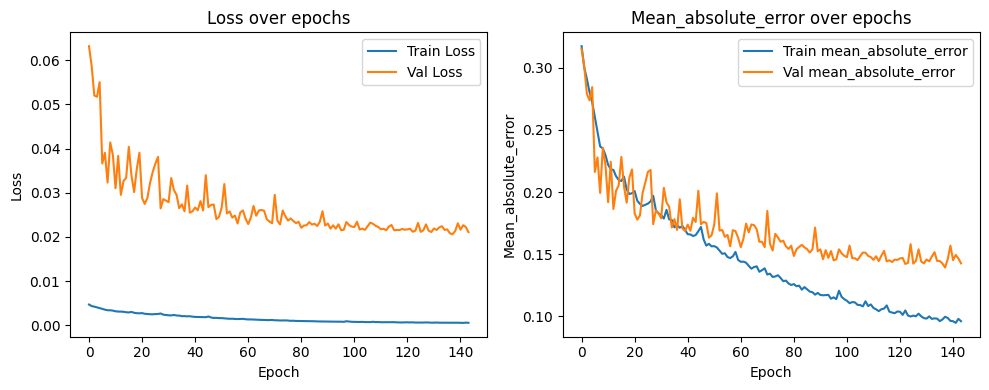

In [17]:
# Теперь можно передать в функцию
plot_learning_curves(type("History", (object,), {"history": full_history}), 'mean_absolute_error')

In [ ]:
results_df_cnn, mse, mae, r2 = evaluate_regression_model(cnn_model, X_test_cnn, y_test)

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201 - mean_absolute_error: 0.1374
Test Loss (MSE): 0.02110
Test MAE: 0.14253
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.04406
Mean Absolute Error (MAE): 0.14253
R² Score: 0.71119


In [ ]:
results_df_cnn.to_csv("cnn_predictions.csv", index=False)

## LSTM (embeddings)

In [32]:
# Меняем оси обратно, чтобы получить (26248, 26, 640, 2)
X_reordered = np.transpose(X_cnn, (0, 2, 1, 3))  # (26248, 26, 640, 2)

# Объединяем два последних измерения (640 + 640 = 1280)
X_lstm = X_reordered.reshape(X_reordered.shape[0], X_reordered.shape[1], -1)  # (26248, 26, 1280)

# Проверяем размерность
print(f"✅ X_lstm готов! Размер: {X_lstm.shape}")  # (26248, 26, 1280)

✅ X_lstm готов! Размер: (26248, 26, 1280)


In [40]:
X_lstm = np.concatenate((genome_embeddings_no_mean, sgRNA_embeddings_no_mean), axis=2)  # (26248, 26, 1280)
X_lstm.shape

(26248, 26, 1280)

In [54]:
y = df["mean_relative_gamma"].values
y = np.array(y, dtype=np.float32)

In [55]:
EMBEDDING_SIZE = 1280
DROPOUT_RATE = 0.1
LEARNING_RATE = 1e-4
EPOCHS = 20  # Уменьшено для быстрого обучения
BATCH_SIZE = 128
HIDDEN_SIZE = 256  # Размер скрытого состояния для LSTM

In [56]:
class LSTMPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(EMBEDDING_SIZE, HIDDEN_SIZE, num_layers=2, batch_first=True, dropout=DROPOUT_RATE)
        self.fc = nn.Sequential(
            nn.Linear(HIDDEN_SIZE, 128),
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),
            nn.Linear(128, 1)  # Выход 1 нейрон (регрессия)
        )
    
    def forward(self, x):
        x, _ = self.lstm(x)  # LSTM выводит (batch, seq_len, hidden_size)
        x = x[:, -1, :]  # Берем последний временной шаг (batch, hidden_size)
        return self.fc(x)

In [ ]:
X_train_lstm, X_test_lstm, _, _ = train_test_split(X_lstm, y, test_size=0.2, random_state=42)

# Преобразование в тензоры
X_train_tensor = torch.tensor(X_train_lstm, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_lstm, dtype=torch.float32)
y_train_tensor = torch.from_numpy(y_train).view(-1, 1)
y_test_tensor = torch.from_numpy(y_test).view(-1, 1)

In [ ]:
# Датасеты и загрузчики
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [57]:
# Инициализация модели
model = LSTMPredictor()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Оптимизатор и функция потерь
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
criterion = nn.MSELoss()

### v1 (epochs=20)

In [50]:
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Валидация
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/20, Train Loss: 0.1537, Val Loss: 0.1496
Epoch 2/20, Train Loss: 0.1478, Val Loss: 0.1497
Epoch 3/20, Train Loss: 0.1461, Val Loss: 0.1446
Epoch 4/20, Train Loss: 0.1431, Val Loss: 0.1413
Epoch 5/20, Train Loss: 0.1327, Val Loss: 0.1313
Epoch 6/20, Train Loss: 0.1165, Val Loss: 0.1093
Epoch 7/20, Train Loss: 0.1053, Val Loss: 0.1068
Epoch 8/20, Train Loss: 0.0992, Val Loss: 0.1029
Epoch 9/20, Train Loss: 0.0950, Val Loss: 0.1157
Epoch 10/20, Train Loss: 0.0937, Val Loss: 0.0939
Epoch 11/20, Train Loss: 0.0927, Val Loss: 0.0945
Epoch 12/20, Train Loss: 0.0894, Val Loss: 0.0947
Epoch 13/20, Train Loss: 0.0886, Val Loss: 0.0931
Epoch 14/20, Train Loss: 0.0873, Val Loss: 0.0958
Epoch 15/20, Train Loss: 0.0854, Val Loss: 0.0949
Epoch 16/20, Train Loss: 0.0839, Val Loss: 0.0956
Epoch 17/20, Train Loss: 0.0817, Val Loss: 0.1007
Epoch 18/20, Train Loss: 0.0821, Val Loss: 0.0989
Epoch 19/20, Train Loss: 0.0831, Val Loss: 0.0938
Epoch 20/20, Train Loss: 0.0802, Val Loss: 0.0917


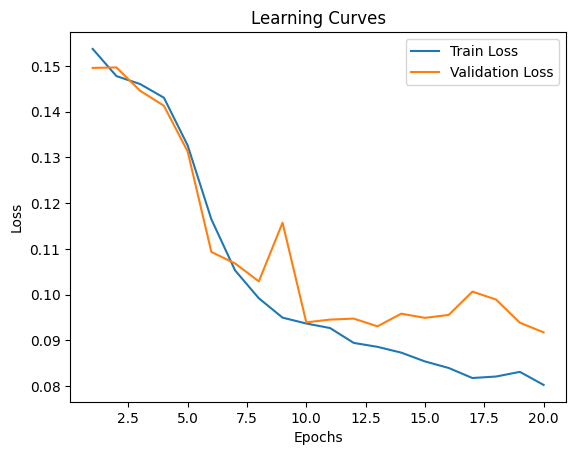

Final R^2 Score: 0.4325


In [78]:
# График кривых обучения
plt.plot(range(1, EPOCHS+1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Learning Curves")
plt.show()

# Оценка модели
model.eval()
y_pred_lstm = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        preds = model(X_batch)
        y_pred_lstm.append(preds.cpu().numpy())
        y_true.append(y_batch.cpu().numpy())

y_pred_lstm = np.concatenate(y_pred_lstm).flatten()
y_true = np.concatenate(y_true).flatten()

r2 = r2_score(y_true, y_pred_lstm)
print(f"Final R^2 Score: {r2:.4f}")

### v2 

In [58]:
EPOCHS = 100

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Валидация
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/100, Train Loss: 0.1521, Val Loss: 0.1498
Epoch 2/100, Train Loss: 0.1481, Val Loss: 0.1476
Epoch 3/100, Train Loss: 0.1452, Val Loss: 0.1523
Epoch 4/100, Train Loss: 0.1444, Val Loss: 0.1485
Epoch 5/100, Train Loss: 0.1318, Val Loss: 0.1236
Epoch 6/100, Train Loss: 0.1115, Val Loss: 0.1518
Epoch 7/100, Train Loss: 0.1037, Val Loss: 0.1033
Epoch 8/100, Train Loss: 0.0981, Val Loss: 0.1051
Epoch 9/100, Train Loss: 0.0941, Val Loss: 0.0966
Epoch 10/100, Train Loss: 0.0929, Val Loss: 0.1041
Epoch 11/100, Train Loss: 0.0900, Val Loss: 0.0985
Epoch 12/100, Train Loss: 0.0877, Val Loss: 0.0966
Epoch 13/100, Train Loss: 0.0861, Val Loss: 0.0948
Epoch 14/100, Train Loss: 0.0856, Val Loss: 0.0974
Epoch 15/100, Train Loss: 0.0836, Val Loss: 0.0963
Epoch 16/100, Train Loss: 0.0826, Val Loss: 0.0980
Epoch 17/100, Train Loss: 0.0823, Val Loss: 0.0976
Epoch 18/100, Train Loss: 0.0809, Val Loss: 0.0992
Epoch 19/100, Train Loss: 0.0803, Val Loss: 0.0922
Epoch 20/100, Train Loss: 0.0797, Val Lo

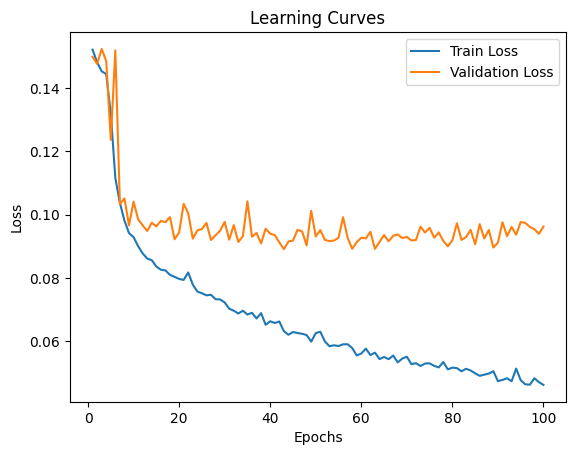

Final R^2 Score: 0.4119


In [59]:
# График кривых обучения
plt.plot(range(1, EPOCHS+1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Learning Curves")
plt.show()

# Оценка модели
model.eval()
y_pred_lstm = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        preds = model(X_batch)
        y_pred_lstm.append(preds.cpu().numpy())
        y_true.append(y_batch.cpu().numpy())

y_pred_lstm = np.concatenate(y_pred_lstm).flatten()
y_true = np.concatenate(y_true).flatten()

r2 = r2_score(y_true, y_pred_lstm)
print(f"Final R^2 Score: {r2:.4f}")

In [43]:
import gc
import tensorflow as tf

# Оставляем только нужные переменные
keep_vars = ["train_dataset", "test_dataset", "train_loader", "test_loader", "X_lstm", "keep_vars"],

In [44]:
# Удаляем все переменные, кроме нужных
for var in dir():
    if var not in keep_vars and not var.startswith("_"):
        del globals()[var]

# Принудительно вызываем сборщик мусора
gc.collect()

# Чистим кэш в TensorFlow (если используешь GPU)
tf.keras.backend.clear_session()

print("✅ Очищена память, остались только нужные переменные!")

NameError: name 'keep_vars' is not defined

## CNN from ExsgRNA (RNA-FM embeddings)

In [13]:
# Транспонируем, чтобы поменять оси местами (640, 26) → (26, 640)
genome_transposed = np.transpose(genome_embeddings_no_mean, (0, 2, 1))  # (26248, 640, 26)
sgRNA_transposed = np.transpose(sgRNA_embeddings_no_mean, (0, 2, 1))  # (26248, 640, 26)

# Объединяем по оси последовательностей (добавляем размерность 2)
X_cnn = np.stack([genome_transposed, sgRNA_transposed], axis=-1)  # (26248, 640, 26, 2)

# Проверяем размерность
print(f"✅ X готов! Размер: {X_cnn.shape}")  # (26248, 640, 26, 2)

✅ X готов! Размер: (26248, 640, 26, 2)


In [ ]:
X_cnn = X_cnn.astype(np.float32)

print(X_cnn.shape)
y = df["mean_relative_gamma"].values
y = np.array(y, dtype=np.float32)

X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42)

print(f"X_train_cnn shape: {X_train_cnn.shape}")
print(f"y_train shape: {y_train.shape}")

(26248, 640, 26, 2)
X_train_cnn shape: (20998, 640, 26, 2)
y_train shape: (20998,)


In [18]:
sample_weights_f=[]
class_weights_f={}
class_number_f=[0,0,0,0,0,0]
for i in range(0,len(y_train)):
	if y_train[i] <= 0.2:
		class_number_f[0]=class_number_f[0]+1
	elif y_train[i] > 0.2 and y_train[i] <= 0.4 :
		class_number_f[1]=class_number_f[1]+1
	elif y_train[i] > 0.4 and y_train[i] <= 0.6 :
		class_number_f[2]=class_number_f[2]+1
	elif y_train[i] > 0.6 and y_train[i] <= 0.8 :
		class_number_f[3]=class_number_f[3]+1
	elif y_train[i] > 0.8 and y_train[i] <= 1.0 :
		class_number_f[4]=class_number_f[4]+1
	elif y_train[i] > 1.0:
		class_number_f[5]=class_number_f[5]+1

print(class_number_f)

class_bin_f=[1/float(class_number_f[0]),1/float(class_number_f[1]),
             1/float(class_number_f[2]),1/float(class_number_f[3]),
             1/float(class_number_f[4]),1/float(class_number_f[5])]

class_weights_f['0']=class_bin_f[0]/sum(class_bin_f)
class_weights_f['1']=class_bin_f[1]/sum(class_bin_f)
class_weights_f['2']=class_bin_f[2]/sum(class_bin_f)
class_weights_f['3']=class_bin_f[3]/sum(class_bin_f)
class_weights_f['4']=class_bin_f[4]/sum(class_bin_f)	
class_weights_f['5']=class_bin_f[5]/sum(class_bin_f)

print(class_weights_f)
	
for i in range(0,len(y_train)):
	if y_train[i] <= 0.2:
		sample_weights_f.append(class_weights_f['0'])
	elif y_train[i] > 0.2 and y_train[i] <= 0.4 :
		sample_weights_f.append(class_weights_f['1'])
	elif y_train[i] > 0.4 and y_train[i] <= 0.6 :
		sample_weights_f.append(class_weights_f['2'])
	elif y_train[i] > 0.6 and y_train[i] <= 0.8 :
		sample_weights_f.append(class_weights_f['3'])
	elif y_train[i] > 0.8 and y_train[i] <= 1.0 :
		sample_weights_f.append(class_weights_f['4'])
	elif y_train[i] > 1.0:
		sample_weights_f.append(class_weights_f['5'])	

sample_weights_f=np.array(sample_weights_f)

[12968, 1552, 1518, 1773, 1766, 1421]
{'0': 0.023991308015249593, '1': 0.20046345511711128, '2': 0.20495341392737598, '3': 0.17547618857403088, '4': 0.17617173405535488, '5': 0.21894390031087735}


In [19]:
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu', padding='same', 
                        input_shape=(640, 26, 2), data_format='channels_last', name = 'conv_1'))
cnn_model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu', padding='same', data_format='channels_last', name = 'dense_2'))
cnn_model.add(MaxPool2D(pool_size=(1,2), padding='same', data_format='channels_last', name = 'dense_3'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=256, activation='sigmoid', name = 'dense_4'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(units=128, activation='sigmoid', name = 'float_dense_5'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(1, activation='linear',name = 'float_dense_7'))
cnn_model.compile(loss='log_cosh', metrics=['mean_absolute_error'], optimizer='Adam')

d:\polina\CRISPR\RNA-FM\ensemble\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
history_list = []

batch_size = 256
epochs_per_step = 8
total_epochs = 10

for step in range(total_epochs // epochs_per_step):
    print(f"Step {step+1}/{total_epochs // epochs_per_step}")

    history = cnn_model.fit(
        X_train_cnn, y_train,
        sample_weight=np.array(sample_weights_f),
        batch_size=batch_size,
        epochs=(step + 1) * epochs_per_step,  # ✅ Указываем общие эпохи, а не сбрасываем
        initial_epoch=step * epochs_per_step,  # ✅ Продолжаем с последней эпохи
        validation_data=(X_test_cnn, y_test),
        shuffle=True
    )
    
    history_list.append(history.history)

Step 1/1
Epoch 1/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - loss: 0.0119 - mean_absolute_error: 0.5379 - val_loss: 0.1148 - val_mean_absolute_error: 0.4533
Epoch 2/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - loss: 0.0075 - mean_absolute_error: 0.4652 - val_loss: 0.1303 - val_mean_absolute_error: 0.4815
Epoch 3/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 227s 3s/step - loss: 0.0068 - mean_absolute_error: 0.4639 - val_loss: 0.1193 - val_mean_absolute_error: 0.4617
Epoch 4/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 224s 3s/step - loss: 0.0067 - mean_absolute_error: 0.4673 - val_loss: 0.1063 - val_mean_absolute_error: 0.4369
Epoch 5/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - loss: 0.0066 - mean_absolute_error: 0.4509 - val_loss: 0.1080 - val_mean_absolute_error: 0.4403
Epoch 6/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - loss: 0.0065 - mean_absolute_error: 0.4574 - val_loss: 0.1184 - val_mean_absolute_error: 0.4600
Epoch 7/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - loss: 0.0066 - mean_absolute_error: 0.4595 - val_lo

In [ ]:
del history
gc.collect()

In [28]:
# Объединяем все эпохи в один словарь
full_history = {key: sum([h[key] for h in history_list], []) for key in history_list[0]}

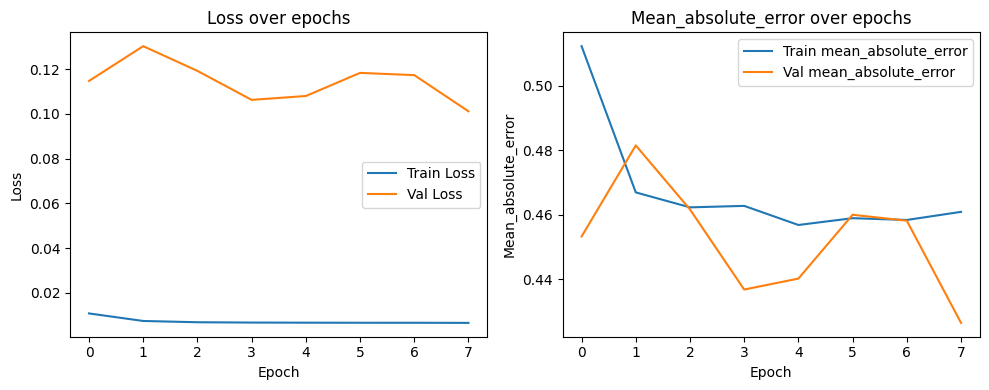

In [29]:
# Теперь можно передать в функцию
plot_learning_curves(type("History", (object,), {"history": full_history}), 'mean_absolute_error')

In [30]:
results_df_cnn, mse, mae, r2 = evaluate_regression_model(cnn_model, X_test_cnn, y_test)

165/165 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - loss: 0.1020 - mean_absolute_error: 0.4290
Test Loss (MSE): 0.10119
Test MAE: 0.42655
165/165 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.21220
Mean Absolute Error (MAE): 0.42655
R² Score: -0.39106


In [ ]:
# results_df_cnn.to_csv("cnn_predictions.csv", index=False)

# Объединение моделей

## Усреднение выходов

In [55]:
results_df = pd.read_csv("cnn_predictions.csv")
results_df.rename(columns={'y_pred': 'y_pred_cnn'}, inplace=True)

In [56]:
results_df["y_pred_lstm"] = y_pred_lstm

In [76]:
alpha = 1
results_df["y_pred_ensemble"] = alpha * results_df["y_pred_cnn"] + (1 - alpha) * results_df["y_pred_lstm"]

r2_cnn = r2_score(results_df["y_test"], results_df["y_pred_cnn"])
r2_lstm = r2_score(results_df["y_test"], results_df["y_pred_lstm"])
r2_ensemble = r2_score(results_df["y_test"], results_df["y_pred_ensemble"])

print(f"R² CNN: {r2_cnn:.4f}")
print(f"R² LSTM: {r2_lstm:.4f}")
print(f"R² ансамбля: {r2_ensemble:.4f}")

R² CNN: 0.7112
R² LSTM: 0.4325
R² ансамбля: 0.7112


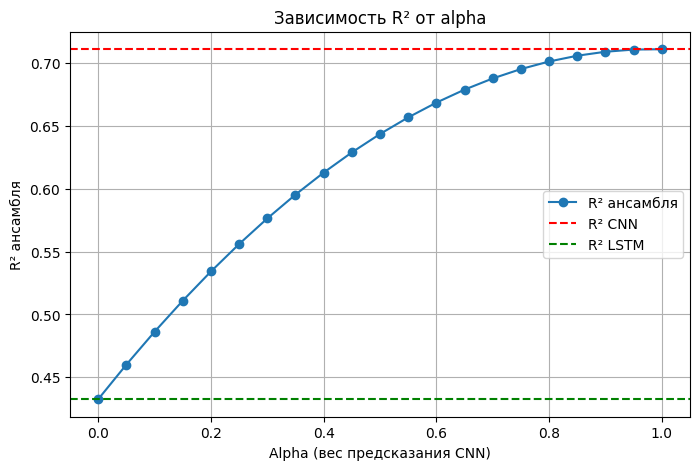

In [ ]:
alpha_values = np.linspace(0, 1, 21)
r2_ensemble_values = []

# Истинные значения
y_true = results_df["y_test"].values
y_pred_cnn = results_df["y_pred_cnn"].values
y_pred_lstm = results_df["y_pred_lstm"].values

# Вычисляем R^2 для каждого значения alpha
for alpha in alpha_values:
    y_pred_ensemble = alpha * y_pred_cnn + (1 - alpha) * y_pred_lstm
    r2_ensemble = r2_score(y_true, y_pred_ensemble)
    r2_ensemble_values.append(r2_ensemble)

# R^2 отдельных моделей
r2_cnn = r2_score(y_true, y_pred_cnn)
r2_lstm = r2_score(y_true, y_pred_lstm)

# Строим график зависимости R^2 ансамбля от alpha
plt.figure(figsize=(8, 5))
plt.plot(alpha_values, r2_ensemble_values, marker='o', linestyle='-', label="R² ансамбля")
plt.axhline(y=r2_cnn, color='r', linestyle='--', label="R² CNN")
plt.axhline(y=r2_lstm, color='g', linestyle='--', label="R² LSTM")
plt.xlabel("Alpha (вес предсказания CNN)")
plt.ylabel("R² ансамбля")
plt.title("Зависимость R² от alpha")
plt.legend()
plt.grid(True)
plt.show()

## Стекинг

In [92]:
from sklearn.ensemble import RandomForestRegressor

# 🔹 1. Разделяем X_train_cnn и X_train_lstm **одинаково**
X_train_cnn_meta, X_val_cnn_meta, y_train_meta, y_val_meta = train_test_split(X_train_cnn, y_train, test_size=0.2, random_state=42)
X_train_lstm_meta, X_val_lstm_meta, _, _ = train_test_split(X_train_lstm, y_train, test_size=0.2, random_state=42)  # Тот же seed!

# 🔹 2. CNN и LSTM делают предсказания на своих X_meta_train (валидационные данные)
y_pred_cnn_train = cnn_model.predict(X_train_cnn_meta)
y_pred_cnn_val = cnn_model.predict(X_val_cnn_meta)

525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
model.eval()

def get_lstm_predictions(model, X_data, batch_size=32):
    """Функция для получения предсказаний LSTM"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    y_pred = []
    X_tensor = torch.tensor(X_data, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        for i in range(0, len(X_data), batch_size):
            batch = X_tensor[i:i+batch_size]
            preds = model(batch)
            y_pred.append(preds.cpu().numpy())

    return np.concatenate(y_pred).flatten()

# Получаем предсказания LSTM
y_pred_lstm_train = get_lstm_predictions(model, X_train_lstm_meta)
y_pred_lstm_val = get_lstm_predictions(model, X_val_lstm_meta)
y_pred_lstm_test = get_lstm_predictions(model, X_test_lstm)

In [93]:
# Создаём X_meta_train и X_meta_val
X_meta_train = np.column_stack([y_pred_cnn_train, y_pred_lstm_train])
X_meta_val = np.column_stack([y_pred_cnn_val, y_pred_lstm_val])

# Обучаем мета-модель
meta_model = RandomForestRegressor(n_estimators=100, random_state=42)
meta_model.fit(X_meta_train, y_train_meta)

# Делаем предсказания мета-моделью
y_pred_meta_val = meta_model.predict(X_meta_val)
r2_meta_val = r2_score(y_val_meta, y_pred_meta_val)

print(f"R² для мета-модели на валидации: {r2_meta_val:.4f}")

# Тестируем на X_test
y_pred_cnn_test = cnn_model.predict(X_test_cnn)
X_meta_test = np.column_stack([y_pred_cnn_test, y_pred_lstm_test])
y_pred_meta_test = meta_model.predict(X_meta_test)
r2_meta_test = r2_score(y_test, y_pred_meta_test)

print(f"R² для мета-модели на тесте: {r2_meta_test:.4f}")

R² для мета-модели на валидации: 0.9455
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
R² для мета-модели на тесте: 0.7122


In [91]:
from sklearn.neural_network import MLPRegressor

# Обучаем мета-модель MLP
meta_model_mlp = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
meta_model_mlp.fit(X_meta_train, y_train_meta)

# Делаем предсказания мета-моделью MLP
y_pred_meta_val_mlp = meta_model_mlp.predict(X_meta_val)
r2_meta_val_mlp = r2_score(y_val_meta, y_pred_meta_val_mlp)

print(f"R² для мета-модели MLP на валидации: {r2_meta_val_mlp:.4f}")

# Тестируем MLP на X_test
y_pred_meta_test_mlp = meta_model_mlp.predict(X_meta_test)
r2_meta_test_mlp = r2_score(y_test, y_pred_meta_test_mlp)

print(f"R² для мета-модели MLP на тесте: {r2_meta_test_mlp:.4f}")

R² для мета-модели MLP на валидации: 0.9529
R² для мета-модели MLP на тесте: 0.7225


### Добавление признаков и регуляризации

In [104]:
print("y_pred_cnn_train shape:", y_pred_cnn_train.shape)
print("y_pred_lstm_train shape:", y_pred_lstm_train.shape)

# Убедимся, что предсказания — одномерные векторы (если нет, исправляем)
y_pred_cnn_train = y_pred_cnn_train.flatten()
y_pred_lstm_train = y_pred_lstm_train.flatten()

# Проверяем снова
print("y_pred_cnn_train shape после flatten:", y_pred_cnn_train.shape)
print("y_pred_lstm_train shape после flatten:", y_pred_lstm_train.shape)

y_pred_cnn_train shape: (16798,)
y_pred_lstm_train shape: (16798,)
y_pred_cnn_train shape после flatten: (16798,)
y_pred_lstm_train shape после flatten: (16798,)


In [106]:
y_pred_cnn_val = y_pred_cnn_val.flatten()
y_pred_lstm_val = y_pred_lstm_val.flatten()

print("y_pred_cnn_val shape:", y_pred_cnn_val.shape)
print("y_pred_lstm_val shape:", y_pred_lstm_val.shape)

y_pred_cnn_val shape: (4200,)
y_pred_lstm_val shape: (4200,)


In [112]:
y_pred_cnn_test = y_pred_cnn_test.flatten()
y_pred_lstm_test = y_pred_lstm_test.flatten()

print("y_pred_cnn_test shape:", y_pred_cnn_test.shape)
print("y_pred_lstm_test shape:", y_pred_lstm_test.shape)

y_pred_cnn_test shape: (5250,)
y_pred_lstm_test shape: (5250,)


In [113]:
# Добавляем новые признаки для мета-модели
X_meta_train_extended = np.column_stack([
    y_pred_cnn_train, 
    y_pred_lstm_train, 
    np.abs(y_pred_cnn_train - y_pred_lstm_train),  # Разница по модулю
    y_pred_cnn_train * y_pred_lstm_train           # Произведение предсказаний
])

print("X_meta_train_extended shape:", X_meta_train_extended.shape)

X_meta_val_extended = np.column_stack([
    y_pred_cnn_val, 
    y_pred_lstm_val, 
    np.abs(y_pred_cnn_val - y_pred_lstm_val), 
    y_pred_cnn_val * y_pred_lstm_val
])

print("X_meta_val_extended shape после исправления:", X_meta_val_extended.shape)

X_meta_test_extended = np.column_stack([
    y_pred_cnn_test, 
    y_pred_lstm_test, 
    np.abs(y_pred_cnn_test - y_pred_lstm_test), 
    y_pred_cnn_test * y_pred_lstm_test
])

print("X_meta_test_extended shape:", X_meta_test_extended.shape)

X_meta_train_extended shape: (16798, 4)
X_meta_val_extended shape после исправления: (4200, 4)
X_meta_test_extended shape: (5250, 4)


In [115]:
# Обучаем MLP с L2-регуляризацией (alpha = 0.01 - это L2-регуляризация)
meta_model_mlp_l2 = MLPRegressor(hidden_layer_sizes=(64, 32), alpha=0.01, max_iter=500, random_state=42)
meta_model_mlp_l2.fit(X_meta_train_extended, y_train_meta)

# Делаем предсказания мета-моделью MLP (с L2)
y_pred_meta_val_mlp_l2 = meta_model_mlp_l2.predict(X_meta_val_extended)
r2_meta_val_mlp_l2 = r2_score(y_val_meta, y_pred_meta_val_mlp_l2)

print(f"R² для MLP (с L2-регуляризацией) на валидации: {r2_meta_val_mlp_l2:.4f}")

# Тестируем MLP с L2 на X_test
print("X_meta_test_extended shape:", X_meta_test_extended.shape)
assert X_meta_test_extended.shape[1] == 4, "Ошибка! X_meta_test_extended имеет неправильное количество признаков!"
y_pred_meta_test_mlp_l2 = meta_model_mlp_l2.predict(X_meta_test_extended)
r2_meta_test_mlp_l2 = r2_score(y_test, y_pred_meta_test_mlp_l2)

print(f"R² для MLP (с L2-регуляризацией) на тесте: {r2_meta_test_mlp_l2:.4f}")

R² для MLP (с L2-регуляризацией) на валидации: 0.9532
X_meta_test_extended shape: (5250, 4)
R² для MLP (с L2-регуляризацией) на тесте: 0.7219


#### v3

In [116]:
from sklearn.neural_network import MLPRegressor

# Новый MLP с более сильной регуляризацией
meta_model_mlp_l2 = MLPRegressor(
    hidden_layer_sizes=(32, 16),  # Уменьшаем нейроны
    alpha=0.05,  # Усиливаем L2-регуляризацию
    max_iter=1000,  # Дольше учимся, чтобы EarlyStopping успел сработать
    random_state=42,
    early_stopping=True  # Останавливаемся, если валидация ухудшается
)

# Обучаем модель
meta_model_mlp_l2.fit(X_meta_train_extended, y_train_meta)

# Делаем предсказания
y_pred_meta_val_mlp_l2 = meta_model_mlp_l2.predict(X_meta_val_extended)
r2_meta_val_mlp_l2 = r2_score(y_val_meta, y_pred_meta_val_mlp_l2)

y_pred_meta_test_mlp_l2 = meta_model_mlp_l2.predict(X_meta_test_extended)
r2_meta_test_mlp_l2 = r2_score(y_test, y_pred_meta_test_mlp_l2)

print(f"✅ R² для MLP (с уменьшенным переобучением) на валидации: {r2_meta_val_mlp_l2:.4f}")
print(f"✅ R² для MLP (с уменьшенным переобучением) на тесте: {r2_meta_test_mlp_l2:.4f}")

✅ R² для MLP (с уменьшенным переобучением) на валидации: 0.9529
✅ R² для MLP (с уменьшенным переобучением) на тесте: 0.7218


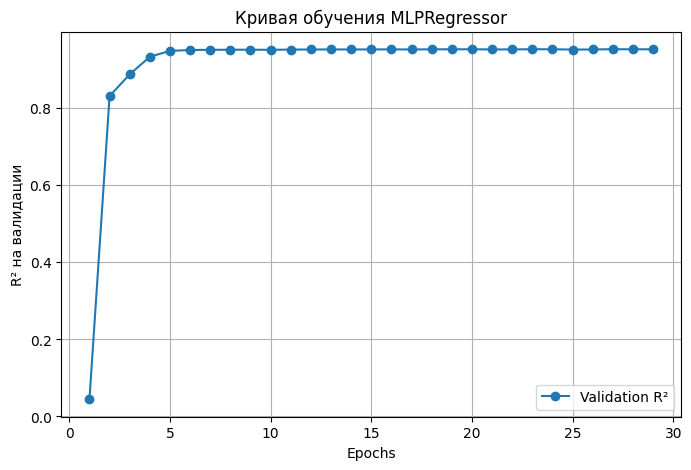

In [117]:
import matplotlib.pyplot as plt

# История обучения
train_scores = meta_model_mlp_l2.validation_scores_

# Создаём график
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_scores) + 1), train_scores, marker="o", label="Validation R²")
plt.xlabel("Epochs")
plt.ylabel("R² на валидации")
plt.title("Кривая обучения MLPRegressor")
plt.legend()
plt.grid()
plt.show()

Epoch 10/100 → Train R²: 0.9523, Val R²: 0.9520
Epoch 20/100 → Train R²: 0.9528, Val R²: 0.9526
Epoch 30/100 → Train R²: 0.9527, Val R²: 0.9527
Epoch 40/100 → Train R²: 0.9524, Val R²: 0.9525
Epoch 50/100 → Train R²: 0.9525, Val R²: 0.9524
Epoch 60/100 → Train R²: 0.9528, Val R²: 0.9528
Epoch 70/100 → Train R²: 0.9531, Val R²: 0.9529
Epoch 80/100 → Train R²: 0.9531, Val R²: 0.9529
Epoch 90/100 → Train R²: 0.9531, Val R²: 0.9529
Epoch 100/100 → Train R²: 0.9531, Val R²: 0.9529
✅ R² на тесте после полного обучения: 0.7221


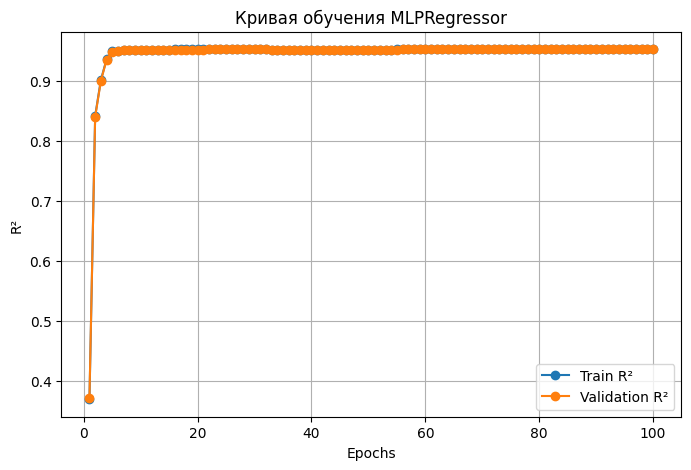

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

# Параметры модели
meta_model_mlp_l2 = MLPRegressor(
    hidden_layer_sizes=(32, 16),  
    alpha=0.05,  # L2-регуляризация
    max_iter=1,  # Один шаг обучения за вызов `partial_fit`
    warm_start=True,  # Позволяет продолжать обучение
    random_state=42
)

# Списки для хранения R²
train_r2_history = []
val_r2_history = []

# Обучение с логированием
EPOCHS = 100  # Количество эпох
for epoch in range(1, EPOCHS + 1):
    meta_model_mlp_l2.partial_fit(X_meta_train_extended, y_train_meta)

    # Считаем R² на train и val
    train_r2 = r2_score(y_train_meta, meta_model_mlp_l2.predict(X_meta_train_extended))
    val_r2 = r2_score(y_val_meta, meta_model_mlp_l2.predict(X_meta_val_extended))

    # Логируем значения
    train_r2_history.append(train_r2)
    val_r2_history.append(val_r2)

    # Вывод прогресса каждые 10 эпох
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{EPOCHS} → Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}")

# Финальное предсказание на тесте
y_pred_meta_test_mlp_l2 = meta_model_mlp_l2.predict(X_meta_test_extended)
r2_meta_test_mlp_l2 = r2_score(y_test, y_pred_meta_test_mlp_l2)
print(f"✅ R² на тесте после полного обучения: {r2_meta_test_mlp_l2:.4f}")

# --- 📊 Строим графики ---
plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS + 1), train_r2_history, label="Train R²", marker="o")
plt.plot(range(1, EPOCHS + 1), val_r2_history, label="Validation R²", marker="o")
plt.xlabel("Epochs")
plt.ylabel("R²")
plt.title("Кривая обучения MLPRegressor")
plt.legend()
plt.grid()
plt.show()

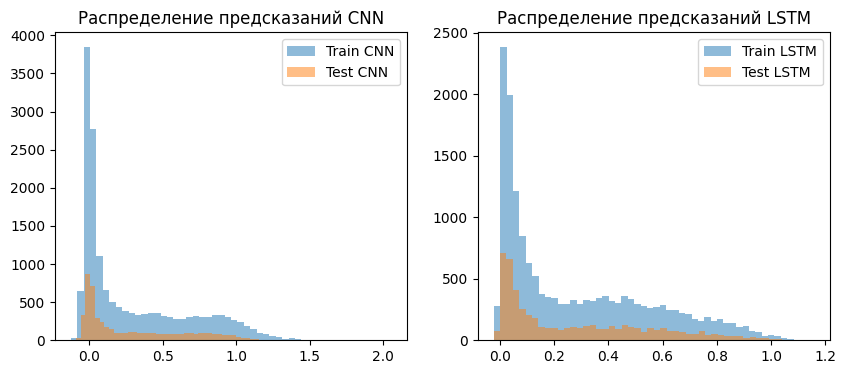

In [119]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(y_pred_cnn_train, bins=50, alpha=0.5, label="Train CNN")
plt.hist(y_pred_cnn_test, bins=50, alpha=0.5, label="Test CNN")
plt.title("Распределение предсказаний CNN")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(y_pred_lstm_train, bins=50, alpha=0.5, label="Train LSTM")
plt.hist(y_pred_lstm_test, bins=50, alpha=0.5, label="Test LSTM")
plt.title("Распределение предсказаний LSTM")
plt.legend()

plt.show()

In [120]:
meta_model_mlp_l2 = MLPRegressor(
    hidden_layer_sizes=(16,),  # Только один скрытый слой
    alpha=0.1,  # Сильнее L2-регуляризация
    max_iter=500,
    random_state=42,
    early_stopping=True
)
meta_model_mlp_l2.fit(X_meta_train_extended, y_train_meta)

r2_meta_test_mlp_l2 = r2_score(y_test, meta_model_mlp_l2.predict(X_meta_test_extended))
print(f"✅ R² на тесте с упрощённой мета-моделью: {r2_meta_test_mlp_l2:.4f}")

✅ R² на тесте с упрощённой мета-моделью: 0.7211


C:\Users\frogs\AppData\Local\Temp\ipykernel_5192\1467253929.py:15: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(y_pred_cnn * y_pred_lstm),  # Корень из произведения


Есть ли NaN в X_meta_train_extended? 3927
Есть ли NaN в X_meta_val_extended? 974
Есть ли NaN в X_meta_test_extended? 1056
X_meta_train_extended shape: (16798, 9)
X_meta_val_extended shape: (4200, 9)
X_meta_test_extended shape: (5250, 9)
Epoch 10/100 → Train R²: 0.9529, Val R²: 0.9527
Epoch 20/100 → Train R²: 0.9528, Val R²: 0.9527
Epoch 30/100 → Train R²: 0.9525, Val R²: 0.9524
Epoch 40/100 → Train R²: 0.9526, Val R²: 0.9524
Epoch 50/100 → Train R²: 0.9528, Val R²: 0.9525
Epoch 60/100 → Train R²: 0.9527, Val R²: 0.9526
Epoch 70/100 → Train R²: 0.9527, Val R²: 0.9525
Epoch 80/100 → Train R²: 0.9527, Val R²: 0.9525
Epoch 90/100 → Train R²: 0.9526, Val R²: 0.9524
Epoch 100/100 → Train R²: 0.9525, Val R²: 0.9523
✅ R² на тесте после расширения признаков: 0.7206


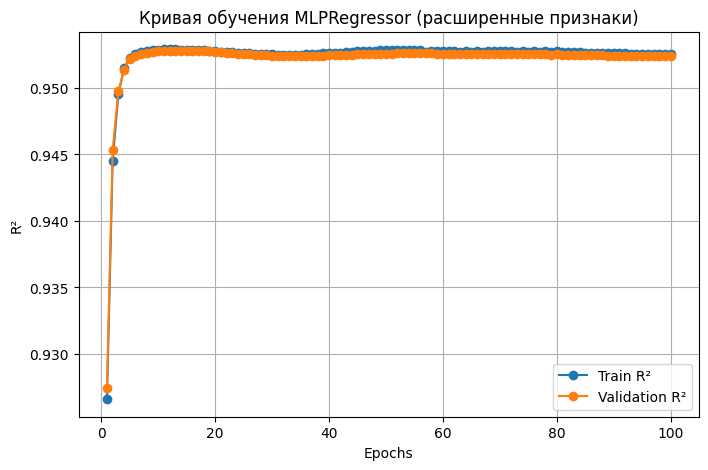

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

# Добавляем новые признаки для мета-модели
def create_extended_features(y_pred_cnn, y_pred_lstm):
    return np.column_stack([
        y_pred_cnn,
        y_pred_lstm,
        np.abs(y_pred_cnn - y_pred_lstm),  # Разница по модулю
        y_pred_cnn * y_pred_lstm,          # Произведение предсказаний
        y_pred_cnn ** 2,                   # Квадраты предсказаний
        y_pred_lstm ** 2,
        np.sqrt(y_pred_cnn * y_pred_lstm),  # Корень из произведения
        np.sign(y_pred_cnn - y_pred_lstm),  # Знак разницы
        np.log(1 + np.abs(y_pred_cnn - y_pred_lstm))  # Логарифм разницы
    ])

# Создаём расширенные фичи
X_meta_train_extended = create_extended_features(y_pred_cnn_train, y_pred_lstm_train)
X_meta_val_extended = create_extended_features(y_pred_cnn_val, y_pred_lstm_val)
X_meta_test_extended = create_extended_features(y_pred_cnn_test, y_pred_lstm_test)

print("Есть ли NaN в X_meta_train_extended?", np.isnan(X_meta_train_extended).sum())
print("Есть ли NaN в X_meta_val_extended?", np.isnan(X_meta_val_extended).sum())
print("Есть ли NaN в X_meta_test_extended?", np.isnan(X_meta_test_extended).sum())

X_meta_train_extended = np.nan_to_num(X_meta_train_extended, nan=0.0)
X_meta_val_extended = np.nan_to_num(X_meta_val_extended, nan=0.0)
X_meta_test_extended = np.nan_to_num(X_meta_test_extended, nan=0.0)

# Проверяем новые размерности
print("X_meta_train_extended shape:", X_meta_train_extended.shape)
print("X_meta_val_extended shape:", X_meta_val_extended.shape)
print("X_meta_test_extended shape:", X_meta_test_extended.shape)

# Обучение MLP с логированием метрик
meta_model_mlp_l2 = MLPRegressor(
    hidden_layer_sizes=(32, 16),
    alpha=0.05,
    max_iter=1,
    warm_start=True,
    random_state=42
)

train_r2_history = []
val_r2_history = []

EPOCHS = 100
for epoch in range(1, EPOCHS + 1):
    meta_model_mlp_l2.partial_fit(X_meta_train_extended, y_train_meta)

    train_r2 = r2_score(y_train_meta, meta_model_mlp_l2.predict(X_meta_train_extended))
    val_r2 = r2_score(y_val_meta, meta_model_mlp_l2.predict(X_meta_val_extended))

    train_r2_history.append(train_r2)
    val_r2_history.append(val_r2)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{EPOCHS} → Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}")

# Финальное предсказание на тесте
y_pred_meta_test_mlp_l2 = meta_model_mlp_l2.predict(X_meta_test_extended)
r2_meta_test_mlp_l2 = r2_score(y_test, y_pred_meta_test_mlp_l2)
print(f"✅ R² на тесте после расширения признаков: {r2_meta_test_mlp_l2:.4f}")

# --- 📊 Строим графики ---
plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS + 1), train_r2_history, label="Train R²", marker="o")
plt.plot(range(1, EPOCHS + 1), val_r2_history, label="Validation R²", marker="o")
plt.xlabel("Epochs")
plt.ylabel("R²")
plt.title("Кривая обучения MLPRegressor (расширенные признаки)")
plt.legend()
plt.grid()
plt.show()

## Pipeline

### train-test split

In [12]:
X_cnn = np.stack(df["encoded_7channels"].values)

# Добавим ось канала (в Keras `Conv2D` ожидает 4D input: batch, height, width, channels)
X_cnn = X_cnn[..., np.newaxis]  # Теперь X имеет форму (N, 7, 26, 1)
X_cnn = X_cnn.astype(np.float32)

print(X_cnn.shape)  # (кол-во примеров, 7, 26, 1)

y = df["mean_relative_gamma"].values
y = np.array(y, dtype=np.float32)

X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42)

print(f"X_train_cnn shape: {X_train_cnn.shape}")  # (samples, N, 7)
print(f"y_train shape: {y_train.shape}")  # (samples,)

(26248, 7, 26, 1)
X_train_cnn shape: (20998, 7, 26, 1)
y_train shape: (20998,)


In [13]:
X_lstm = np.concatenate((genome_embeddings_no_mean, sgRNA_embeddings_no_mean), axis=2)  # (26248, 26, 1280)
X_lstm.shape

(26248, 26, 1280)

In [14]:
X_train_lstm, X_test_lstm, _, _ = train_test_split(X_lstm, y, test_size=0.2, random_state=42)

### v1

In [26]:
# --------------------------
# 1) CNN-ветка
# Входные данные теперь (N, 7, 26, 1)
# --------------------------
input_cnn = Input(shape=(7, 26, 1), name='cnn_input')  # (batch, 7, 26, 1)

x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(input_cnn)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
cnn_features = Dense(32, activation='relu')(x)

# --------------------------
# 2) LSTM-ветка
# Вход: эмбеддинги RNA-FM размером (N, 1280)
# --------------------------
input_lstm = Input(shape=(26, 1280), name='lstm_input')  # (batch, 26, 1280)

y = LSTM(64, return_sequences=False)(input_lstm)
y = Dense(32, activation='relu')(y)
lstm_features = Dense(16, activation='relu')(y)

# --------------------------
# 3) Конкатенация признаков
# --------------------------
merged = Concatenate()([cnn_features, lstm_features])

# --------------------------
# 4) Общая голова (MLP) → регрессия
# --------------------------
z = Dense(64, activation='relu')(merged)
z = Dense(32, activation='relu')(z)
output = Dense(1, activation='linear', name='regression_output')(z)

model = Model(inputs=[input_cnn, input_lstm], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_input           │ (None, 7, 26, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 26, 32) │        320 │ cnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 3, 13, 32) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_input          │ (None, 26, 1280)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1248)      │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │    344,320 │ lstm_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │     79,936 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │      2,080 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      2,080 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 16)        │        528 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 48)        │          0 │ dense_7[0][0],    │
│ (Concatenate)       │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      3,136 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32)        │      2,080 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression_output   │ (None, 1)         │         33 │ dense_11[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 434,513 (1.66 MB)

 Trainable params: 434,513 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# --------------------------
# Обучение
# --------------------------
history = model.fit(
    [X_train_cnn, X_train_lstm], y_train,
    epochs=10, batch_size=32,
    validation_data=([X_test_cnn, X_test_lstm], y_test)
)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 64s 54ms/step - loss: 0.0981 - mae: 0.2313 - val_loss: 0.0702 - val_mae: 0.1899
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0687 - mae: 0.1829 - val_loss: 0.0633 - val_mae: 0.1754
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0619 - mae: 0.1712 - val_loss: 0.0595 - val_mae: 0.1628
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.0583 - mae: 0.1634 - val_loss: 0.0597 - val_mae: 0.1727
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.0551 - mae: 0.1591 - val_loss: 0.0644 - val_mae: 0.1606
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0511 - mae: 0.1499 - val_loss: 0.0619 - val_mae: 0.1733
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.0473 - mae: 0.1454 - val_loss: 0.0577 - val_mae: 0.1658
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0452 - mae: 0.1423 - val_loss: 0.0529 - val_mae: 0.1492
Epoch 9/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 

In [30]:
results_df, mse, mae, r2 = evaluate_regression_model(model, [X_test_cnn, X_test_lstm], y_test)

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0517 - mae: 0.1506
Test Loss (MSE): 0.05441
Test MAE: 0.15481
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.05441
Mean Absolute Error (MAE): 0.15481
R² Score: 0.64336


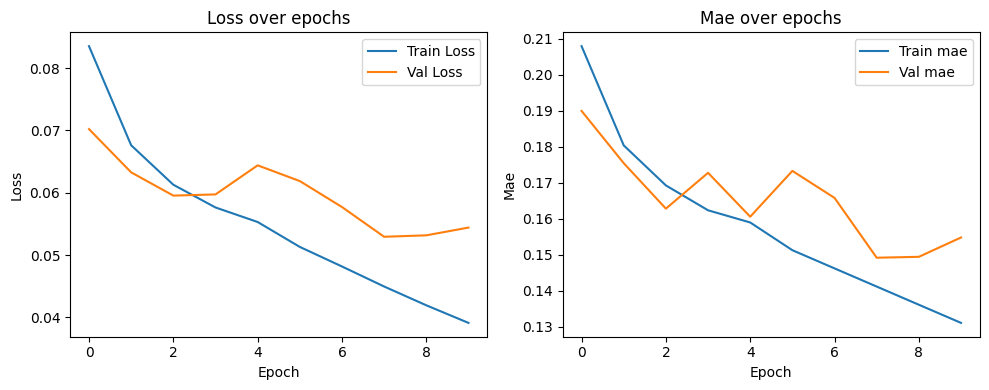

In [31]:
plot_learning_curves(history, metric='mae')

In [32]:
history_continued = model.fit(
    [X_train_cnn, X_train_lstm], y_train,
    epochs=10, batch_size=32,
    validation_data=([X_test_cnn, X_test_lstm], y_test)
)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0351 - mae: 0.1249 - val_loss: 0.0539 - val_mae: 0.1492
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0334 - mae: 0.1208 - val_loss: 0.0532 - val_mae: 0.1475
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0315 - mae: 0.1180 - val_loss: 0.0521 - val_mae: 0.1484
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.0287 - mae: 0.1128 - val_loss: 0.0542 - val_mae: 0.1481
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0270 - mae: 0.1095 - val_loss: 0.0517 - val_mae: 0.1445
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0247 - mae: 0.1059 - val_loss: 0.0536 - val_mae: 0.1516
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0244 - mae: 0.1052 - val_loss: 0.0513 - val_mae: 0.1431
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0237 - mae: 0.1026 - val_loss: 0.0554 - val_mae: 0.1527
Epoch 9/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 

In [33]:
results_df, mse, mae, r2 = evaluate_regression_model(model, [X_test_cnn, X_test_lstm], y_test)

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0482 - mae: 0.1404
Test Loss (MSE): 0.05219
Test MAE: 0.14612
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.05219
Mean Absolute Error (MAE): 0.14612
R² Score: 0.65790


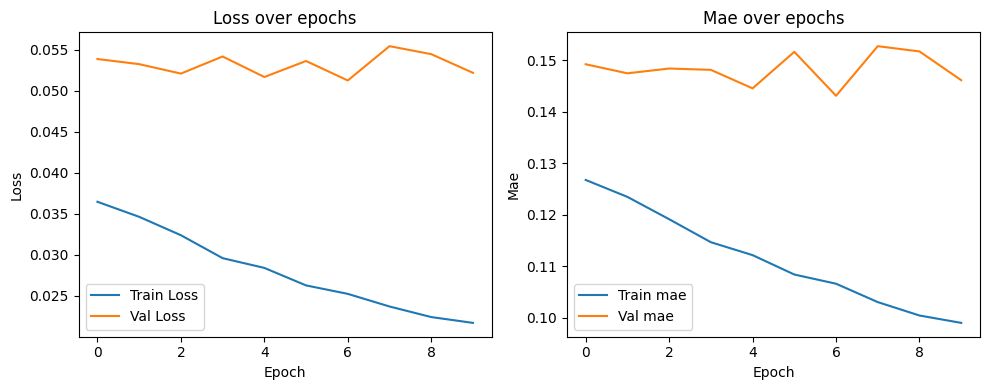

In [34]:
plot_learning_curves(history_continued, metric='mae')

### v2

In [35]:
# --------------------------
# 1) CNN-ветка (обновленная)
# --------------------------
input_cnn = Input(shape=(7, 26, 1), name='cnn_input')  # (batch, 7, 26, 1)

x = Conv2D(filters=32, kernel_size=(4, 4), activation='relu', padding='same', name='conv_1')(input_cnn)
x = Conv2D(filters=32, kernel_size=(4, 4), activation='relu', padding='same', name='conv_2')(x)
x = MaxPooling2D(pool_size=(1, 2), padding='same', name='pool_1')(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(256, activation='sigmoid', name='dense_1')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='sigmoid', name='dense_2')(x)
x = Dropout(0.25)(x)
cnn_features = Dense(32, activation='relu', name='cnn_output')(x)

# --------------------------
# 2) LSTM-ветка
# --------------------------
input_lstm = Input(shape=(26, 1280), name='lstm_input')  # (batch, 26, 1280)

y = LSTM(64, return_sequences=False, name='lstm_1')(input_lstm)
y = Dense(32, activation='relu', name='lstm_dense_1')(y)
lstm_features = Dense(16, activation='relu', name='lstm_output')(y)

# --------------------------
# 3) Конкатенация признаков
# --------------------------
merged = Concatenate(name='concatenate')([cnn_features, lstm_features])

# --------------------------
# 4) Общая голова (MLP) → регрессия
# --------------------------
z = Dense(64, activation='relu', name='dense_3')(merged)
z = Dense(32, activation='relu', name='dense_4')(z)
output = Dense(1, activation='linear', name='regression_output')(z)

# Создаём модель
model = Model(inputs=[input_cnn, input_lstm], outputs=output)
model.compile(loss='log_cosh', metrics=['mean_absolute_error'], optimizer='adam')

model.summary()

# --------------------------
# 5) Вычисление sample weights
# --------------------------
sample_weights_f = []
class_weights_f = {}
class_number_f = [0] * 6  # 6 классов

# Подсчёт количества элементов в каждом классе
for i in range(len(y_train)):
    if y_train[i] <= 0.2:
        class_number_f[0] += 1
    elif y_train[i] <= 0.4:
        class_number_f[1] += 1
    elif y_train[i] <= 0.6:
        class_number_f[2] += 1
    elif y_train[i] <= 0.8:
        class_number_f[3] += 1
    elif y_train[i] <= 1.0:
        class_number_f[4] += 1
    else:
        class_number_f[5] += 1

# Вычисляем веса классов
class_bin_f = [1 / float(n) if n > 0 else 0 for n in class_number_f]
class_bin_f = np.array(class_bin_f) / np.sum(class_bin_f)  # Нормализация

for i in range(6):
    class_weights_f[str(i)] = class_bin_f[i]

# Применение весов к выборке
for i in range(len(y_train)):
    if y_train[i] <= 0.2:
        sample_weights_f.append(class_weights_f['0'])
    elif y_train[i] <= 0.4:
        sample_weights_f.append(class_weights_f['1'])
    elif y_train[i] <= 0.6:
        sample_weights_f.append(class_weights_f['2'])
    elif y_train[i] <= 0.8:
        sample_weights_f.append(class_weights_f['3'])
    elif y_train[i] <= 1.0:
        sample_weights_f.append(class_weights_f['4'])
    else:
        sample_weights_f.append(class_weights_f['5'])

sample_weights_f = np.array(sample_weights_f)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_input           │ (None, 7, 26, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, 7, 26, 32) │        544 │ cnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv2D)     │ (None, 7, 26, 32) │     16,416 │ conv_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_1              │ (None, 7, 13, 32) │          0 │ conv_2[0][0]      │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 7, 13, 32) │          0 │ pool_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 2912)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    745,728 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_input          │ (None, 26, 1280)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │    344,320 │ lstm_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dense_1        │ (None, 32)        │      2,080 │ lstm_1[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_output (Dense)  │ (None, 32)        │      4,128 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_output (Dense) │ (None, 16)        │        528 │ lstm_dense_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 48)        │          0 │ cnn_output[0][0], │
│ (Concatenate)       │                   │            │ lstm_output[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      3,136 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression_output   │ (None, 1)         │         33 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,151,889 (4.39 MB)

 Trainable params: 1,151,889 (4.39 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# --------------------------
# 6) Обучение модели с sample weights
# --------------------------
history = model.fit(
    [X_train_cnn, X_train_lstm], y_train,
    sample_weight=sample_weights_f,
    epochs=10,
    batch_size=32,
    validation_data=([X_test_cnn, X_test_lstm], y_test)
)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.0058 - mean_absolute_error: 0.3729 - val_loss: 0.0676 - val_mean_absolute_error: 0.3262
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - loss: 0.0043 - mean_absolute_error: 0.2963 - val_loss: 0.0390 - val_mean_absolute_error: 0.2260
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.0037 - mean_absolute_error: 0.2511 - val_loss: 0.0389 - val_mean_absolute_error: 0.2321
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.0033 - mean_absolute_error: 0.2318 - val_loss: 0.0311 - val_mean_absolute_error: 0.1899
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - loss: 0.0031 - mean_absolute_error: 0.2137 - val_loss: 0.0386 - val_mean_absolute_error: 0.2147
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.0030 - mean_absolute_error: 0.2036 - val_loss: 0.0292 - val_mean_absolute_error: 0.1817
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - loss: 0.0029 - mean_absolute_err

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0331 - mean_absolute_error: 0.2022
Test Loss (MSE): 0.03495
Test MAE: 0.20867
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.07285
Mean Absolute Error (MAE): 0.20867
R² Score: 0.52246


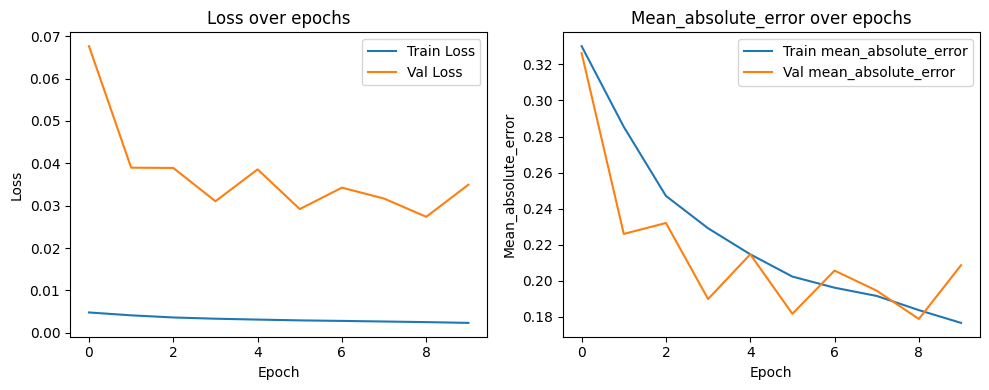

In [37]:
results_df, mse, mae, r2 = evaluate_regression_model(model, [X_test_cnn, X_test_lstm], y_test)
plot_learning_curves(history, metric='mean_absolute_error')

In [38]:
history1 = model.fit(
    [X_train_cnn, X_train_lstm], y_train,
    sample_weight=sample_weights_f,
    epochs=20,
    batch_size=32,
    validation_data=([X_test_cnn, X_test_lstm], y_test)
)

Epoch 1/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - loss: 0.0022 - mean_absolute_error: 0.1728 - val_loss: 0.0288 - val_mean_absolute_error: 0.1839
Epoch 2/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - loss: 0.0021 - mean_absolute_error: 0.1651 - val_loss: 0.0291 - val_mean_absolute_error: 0.1825
Epoch 3/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - loss: 0.0018 - mean_absolute_error: 0.1578 - val_loss: 0.0267 - val_mean_absolute_error: 0.1732
Epoch 4/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - loss: 0.0018 - mean_absolute_error: 0.1521 - val_loss: 0.0309 - val_mean_absolute_error: 0.1862
Epoch 5/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - loss: 0.0016 - mean_absolute_error: 0.1480 - val_loss: 0.0266 - val_mean_absolute_error: 0.1656
Epoch 6/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - loss: 0.0015 - mean_absolute_error: 0.1413 - val_loss: 0.0240 - val_mean_absolute_error: 0.1600
Epoch 7/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - loss: 0.0015 - mean_absolute_err

In [ ]:
results_df, mse, mae, r2 = evaluate_regression_model(model, [X_test_cnn, X_test_lstm], y_test)

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0206 - mean_absolute_error: 0.1397
Test Loss (MSE): 0.02200
Test MAE: 0.14493
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.04598
Mean Absolute Error (MAE): 0.14493
R² Score: 0.69857


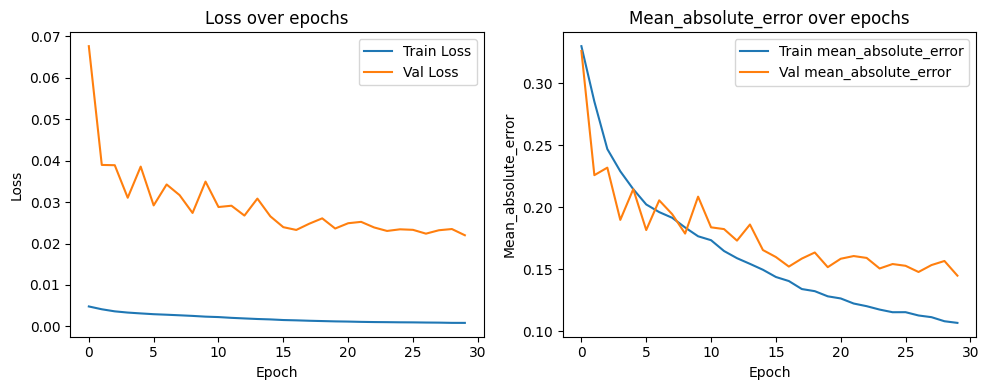

In [ ]:
history_dicts = [history.history, history1.history]
full_history = {key: sum((hist[key] for hist in history_dicts), []) for key in history.history.keys()}

full_history_obj = History()
full_history_obj.history = full_history

plot_learning_curves(full_history_obj, metric='mean_absolute_error')

In [46]:
history2 = model.fit(
    [X_train_cnn, X_train_lstm], y_train,
    sample_weight=sample_weights_f,
    epochs=10,
    batch_size=32,
    validation_data=([X_test_cnn, X_test_lstm], y_test)
)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - loss: 8.0520e-04 - mean_absolute_error: 0.1049 - val_loss: 0.0223 - val_mean_absolute_error: 0.1483
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 7.5925e-04 - mean_absolute_error: 0.1035 - val_loss: 0.0223 - val_mean_absolute_error: 0.1492
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 7.6071e-04 - mean_absolute_error: 0.1028 - val_loss: 0.0228 - val_mean_absolute_error: 0.1474
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 7.4172e-04 - mean_absolute_error: 0.1007 - val_loss: 0.0225 - val_mean_absolute_error: 0.1484
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - loss: 7.1360e-04 - mean_absolute_error: 0.0985 - val_loss: 0.0217 - val_mean_absolute_error: 0.1452
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 7.0958e-04 - mean_absolute_error: 0.0996 - val_loss: 0.0227 - val_mean_absolute_error: 0.1484
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 7.

In [47]:
results_df, mse, mae, r2 = evaluate_regression_model(model, [X_test_cnn, X_test_lstm], y_test)

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0203 - mean_absolute_error: 0.1381
Test Loss (MSE): 0.02160
Test MAE: 0.14301
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.04513
Mean Absolute Error (MAE): 0.14301
R² Score: 0.70419


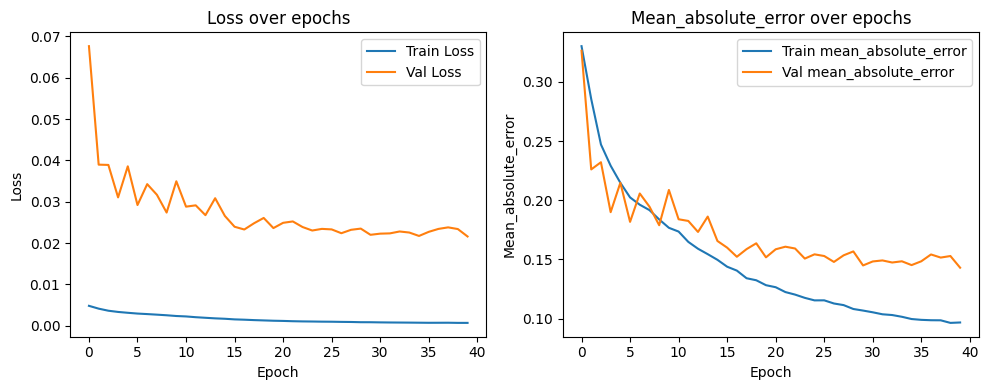

In [48]:
history_dicts = [history.history, history1.history, history2.history]
full_history = {key: sum((hist[key] for hist in history_dicts), []) for key in history.history.keys()}

full_history_obj = History()
full_history_obj.history = full_history

plot_learning_curves(full_history_obj, metric='mean_absolute_error')

### v3

In [16]:
# Гиперпараметры (из твоего PyTorch кода)
EMBEDDING_SIZE = 1280
DROPOUT_RATE = 0.1
LEARNING_RATE = 1e-4
EPOCHS = 20
BATCH_SIZE = 128
HIDDEN_SIZE = 256  # Размер скрытого состояния для LSTM

# --------------------------
# 1) CNN-ветка
# --------------------------
input_cnn = Input(shape=(7, 26, 1), name='cnn_input')  # (batch, 7, 26, 1)

x = Conv2D(filters=32, kernel_size=(4, 4), activation='relu', padding='same', name='conv_1')(input_cnn)
x = Conv2D(filters=32, kernel_size=(4, 4), activation='relu', padding='same', name='conv_2')(x)
x = MaxPooling2D(pool_size=(1, 2), padding='same', name='pool_1')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Flatten()(x)
x = Dense(256, activation='sigmoid', name='dense_1')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(128, activation='sigmoid', name='dense_2')(x)
x = Dropout(DROPOUT_RATE)(x)
cnn_features = Dense(32, activation='relu', name='cnn_output')(x)

# --------------------------
# 2) LSTM-ветка
# --------------------------
input_lstm = Input(shape=(26, EMBEDDING_SIZE), name='lstm_input')  # (batch, 26, 1280)

y = LSTM(HIDDEN_SIZE, return_sequences=False, dropout=DROPOUT_RATE, name='lstm_1')(input_lstm)
y = Dense(128, activation='relu', name='lstm_dense_1')(y)
y = Dropout(DROPOUT_RATE)(y)
lstm_features = Dense(64, activation='relu', name='lstm_output')(y)

# --------------------------
# 3) Конкатенация признаков
# --------------------------
merged = Concatenate(name='concatenate')([cnn_features, lstm_features])

# --------------------------
# 4) Общая голова (MLP) → регрессия
# --------------------------
z = Dense(64, activation='relu', name='dense_3')(merged)
z = Dropout(DROPOUT_RATE)(z)
z = Dense(32, activation='relu', name='dense_4')(z)
output = Dense(1, activation='linear', name='regression_output')(z)

# --------------------------
# Создаём модель
# --------------------------
model = Model(inputs=[input_cnn, input_lstm], outputs=output)
optimizer = Adam(learning_rate=LEARNING_RATE, weight_decay=1e-4)
model.compile(loss='mse', metrics=['mean_absolute_error'], optimizer=optimizer)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_input           │ (None, 7, 26, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, 7, 26, 32) │        544 │ cnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv2D)     │ (None, 7, 26, 32) │     16,416 │ conv_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_1              │ (None, 7, 13, 32) │          0 │ conv_2[0][0]      │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 7, 13, 32) │          0 │ pool_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2912)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    745,728 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_input          │ (None, 26, 1280)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │  1,573,888 │ lstm_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dense_1        │ (None, 128)       │     32,896 │ lstm_1[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ lstm_dense_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_output (Dense)  │ (None, 32)        │      4,128 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_output (Dense) │ (None, 64)        │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ cnn_output[0][0], │
│ (Concatenate)       │                   │            │ lstm_output[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      6,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression_output   │ (None, 1)         │         33 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,423,073 (9.24 MB)

 Trainable params: 2,423,073 (9.24 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
history = model.fit(
    [X_train_cnn, X_train_lstm], y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=([X_test_cnn, X_test_lstm], y_test)
)

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 32s 163ms/step - loss: 0.2042 - mean_absolute_error: 0.3513 - val_loss: 0.1337 - val_mean_absolute_error: 0.3175
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 28s 168ms/step - loss: 0.1180 - mean_absolute_error: 0.2713 - val_loss: 0.0917 - val_mean_absolute_error: 0.2146
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - loss: 0.0930 - mean_absolute_error: 0.2246 - val_loss: 0.0892 - val_mean_absolute_error: 0.2193
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 44s 171ms/step - loss: 0.0902 - mean_absolute_error: 0.2182 - val_loss: 0.0847 - val_mean_absolute_error: 0.2060
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - loss: 0.0850 - mean_absolute_error: 0.2142 - val_loss: 0.0812 - val_mean_absolute_error: 0.2039
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 25s 149ms/step - loss: 0.0831 - mean_absolute_error: 0.2103 - val_loss: 0.0800 - val_mean_absolute_error: 0.2075
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - loss: 0.0815 - mean_absol

165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0674 - mean_absolute_error: 0.1726
Test Loss (MSE): 0.06807
Test MAE: 0.17455
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.06807
Mean Absolute Error (MAE): 0.17455
R² Score: 0.55380


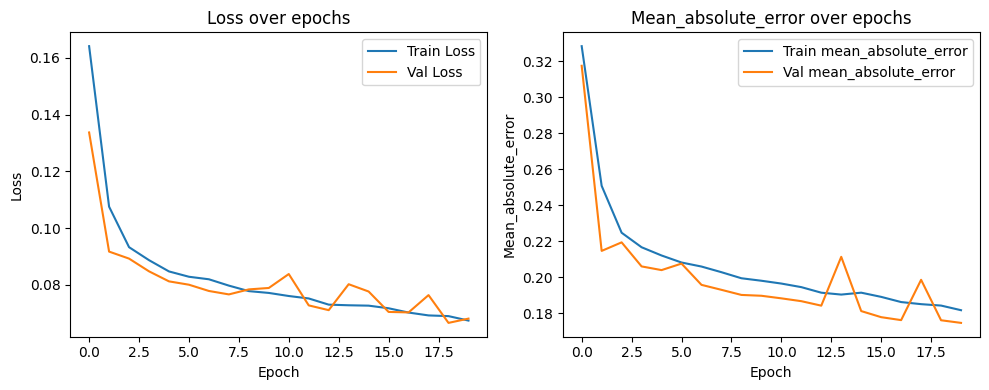

In [54]:
results_df, mse, mae, r2 = evaluate_regression_model(model, [X_test_cnn, X_test_lstm], y_test)
plot_learning_curves(history, metric='mean_absolute_error')

In [55]:
history1 = model.fit(
    [X_train_cnn, X_train_lstm], y_train,
    epochs=10,
    batch_size=BATCH_SIZE,
    validation_data=([X_test_cnn, X_test_lstm], y_test)
)

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 29s 177ms/step - loss: 0.0676 - mean_absolute_error: 0.1825 - val_loss: 0.0657 - val_mean_absolute_error: 0.1766
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 36s 144ms/step - loss: 0.0664 - mean_absolute_error: 0.1796 - val_loss: 0.0644 - val_mean_absolute_error: 0.1737
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - loss: 0.0664 - mean_absolute_error: 0.1799 - val_loss: 0.0635 - val_mean_absolute_error: 0.1713
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 25s 150ms/step - loss: 0.0640 - mean_absolute_error: 0.1745 - val_loss: 0.0637 - val_mean_absolute_error: 0.1733
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 25s 150ms/step - loss: 0.0633 - mean_absolute_error: 0.1738 - val_loss: 0.0624 - val_mean_absolute_error: 0.1726
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 25s 149ms/step - loss: 0.0634 - mean_absolute_error: 0.1748 - val_loss: 0.0621 - val_mean_absolute_error: 0.1696
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - loss: 0.0644 - mean_absol

165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0607 - mean_absolute_error: 0.1700
Test Loss (MSE): 0.06145
Test MAE: 0.17191
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.06145
Mean Absolute Error (MAE): 0.17191
R² Score: 0.59720


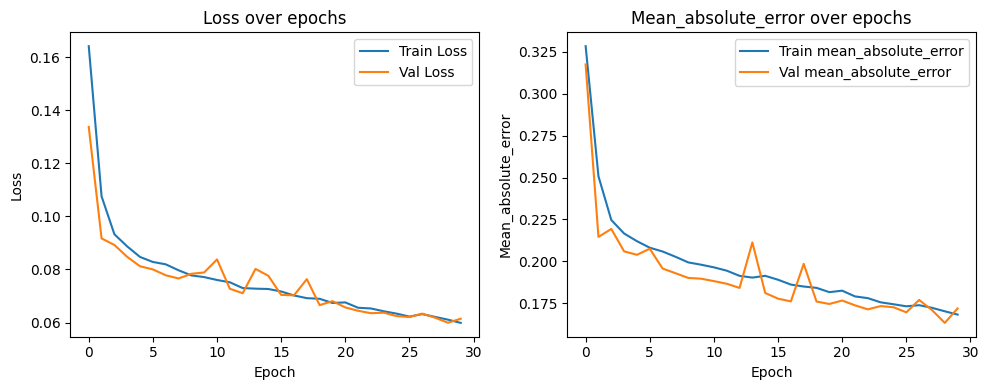

In [56]:
results_df, mse, mae, r2 = evaluate_regression_model(model, [X_test_cnn, X_test_lstm], y_test)

history_dicts = [history.history, history1.history]
full_history = {key: sum((hist[key] for hist in history_dicts), []) for key in history.history.keys()}
full_history_obj = History()
full_history_obj.history = full_history

plot_learning_curves(full_history_obj, metric='mean_absolute_error')

In [57]:
history2 = model.fit(
    [X_train_cnn, X_train_lstm], y_train,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=([X_test_cnn, X_test_lstm], y_test)
)

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 28s 167ms/step - loss: 0.0606 - mean_absolute_error: 0.1694 - val_loss: 0.0587 - val_mean_absolute_error: 0.1633
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - loss: 0.0577 - mean_absolute_error: 0.1651 - val_loss: 0.0606 - val_mean_absolute_error: 0.1625
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 136ms/step - loss: 0.0588 - mean_absolute_error: 0.1658 - val_loss: 0.0588 - val_mean_absolute_error: 0.1630
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - loss: 0.0575 - mean_absolute_error: 0.1637 - val_loss: 0.0577 - val_mean_absolute_error: 0.1604
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - loss: 0.0592 - mean_absolute_error: 0.1679 - val_loss: 0.0585 - val_mean_absolute_error: 0.1594
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 41s 144ms/step - loss: 0.0562 - mean_absolute_error: 0.1629 - val_loss: 0.0571 - val_mean_absolute_error: 0.1581
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 24s 145ms/step - loss: 0.0564 - mean_absol

165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0586 - mean_absolute_error: 0.1519
Test Loss (MSE): 0.05793
Test MAE: 0.15255
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.05793
Mean Absolute Error (MAE): 0.15255
R² Score: 0.62022


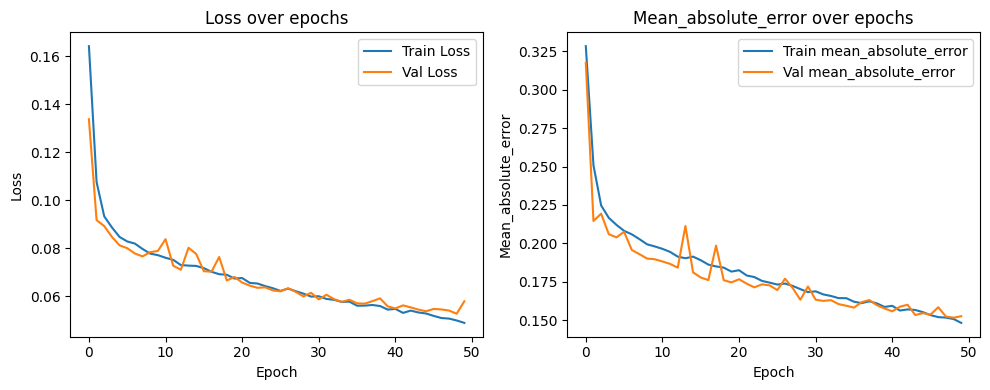

In [58]:
results_df, mse, mae, r2 = evaluate_regression_model(model, [X_test_cnn, X_test_lstm], y_test)

history_dicts = [history.history, history1.history, history2.history]
full_history = {key: sum((hist[key] for hist in history_dicts), []) for key in history.history.keys()}
full_history_obj = History()
full_history_obj.history = full_history

plot_learning_curves(full_history_obj, metric='mean_absolute_error')

In [59]:
history3 = model.fit(
    [X_train_cnn, X_train_lstm], y_train,
    epochs=10,
    batch_size=BATCH_SIZE,
    validation_data=([X_test_cnn, X_test_lstm], y_test)
)

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 26s 160ms/step - loss: 0.0502 - mean_absolute_error: 0.1501 - val_loss: 0.0555 - val_mean_absolute_error: 0.1520
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - loss: 0.0505 - mean_absolute_error: 0.1518 - val_loss: 0.0524 - val_mean_absolute_error: 0.1519
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 24s 144ms/step - loss: 0.0490 - mean_absolute_error: 0.1486 - val_loss: 0.0521 - val_mean_absolute_error: 0.1547
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 41s 141ms/step - loss: 0.0485 - mean_absolute_error: 0.1479 - val_loss: 0.0521 - val_mean_absolute_error: 0.1526
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - loss: 0.0465 - mean_absolute_error: 0.1449 - val_loss: 0.0532 - val_mean_absolute_error: 0.1549
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - loss: 0.0460 - mean_absolute_error: 0.1432 - val_loss: 0.0510 - val_mean_absolute_error: 0.1474
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 25s 148ms/step - loss: 0.0445 - mean_absol

165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0529 - mean_absolute_error: 0.1463
Test Loss (MSE): 0.05326
Test MAE: 0.14769
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.05326
Mean Absolute Error (MAE): 0.14769
R² Score: 0.65088


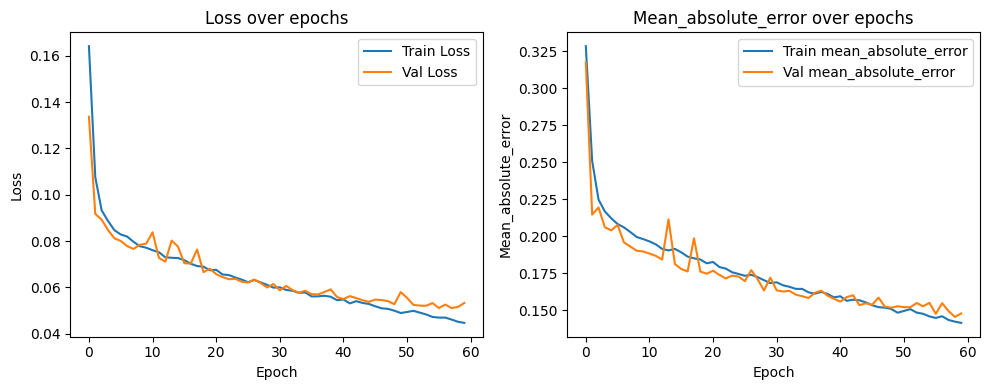

In [60]:
results_df, mse, mae, r2 = evaluate_regression_model(model, [X_test_cnn, X_test_lstm], y_test)

history_dicts = [history.history, history1.history, history2.history, history3.history]
full_history = {key: sum((hist[key] for hist in history_dicts), []) for key in history.history.keys()}
full_history_obj = History()
full_history_obj.history = full_history

plot_learning_curves(full_history_obj, metric='mean_absolute_error')

In [61]:
history4 = model.fit(
    [X_train_cnn, X_train_lstm], y_train,
    epochs=10,
    batch_size=BATCH_SIZE,
    validation_data=([X_test_cnn, X_test_lstm], y_test)
)

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 54s 253ms/step - loss: 0.0459 - mean_absolute_error: 0.1427 - val_loss: 0.0544 - val_mean_absolute_error: 0.1502
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - loss: 0.0440 - mean_absolute_error: 0.1414 - val_loss: 0.0499 - val_mean_absolute_error: 0.1477
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 24s 144ms/step - loss: 0.0455 - mean_absolute_error: 0.1431 - val_loss: 0.0536 - val_mean_absolute_error: 0.1476
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - loss: 0.0426 - mean_absolute_error: 0.1373 - val_loss: 0.0576 - val_mean_absolute_error: 0.1525
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 25s 153ms/step - loss: 0.0463 - mean_absolute_error: 0.1422 - val_loss: 0.0495 - val_mean_absolute_error: 0.1446
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 26s 157ms/step - loss: 0.0437 - mean_absolute_error: 0.1395 - val_loss: 0.0484 - val_mean_absolute_error: 0.1427
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - loss: 0.0439 - mean_absol

165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0474 - mean_absolute_error: 0.1431
Test Loss (MSE): 0.04844
Test MAE: 0.14530
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.04844
Mean Absolute Error (MAE): 0.14530
R² Score: 0.68248


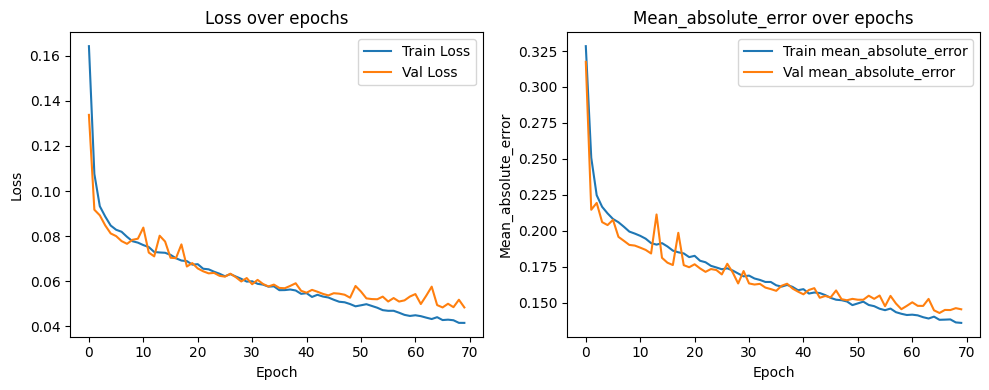

In [62]:
results_df, mse, mae, r2 = evaluate_regression_model(model, [X_test_cnn, X_test_lstm], y_test)

history_dicts = [history.history, history1.history, history2.history, history3.history, history4.history]
full_history = {key: sum((hist[key] for hist in history_dicts), []) for key in history.history.keys()}
full_history_obj = History()
full_history_obj.history = full_history

plot_learning_curves(full_history_obj, metric='mean_absolute_error')

In [63]:
history5 = model.fit(
    [X_train_cnn, X_train_lstm], y_train,
    epochs=10,
    batch_size=BATCH_SIZE,
    validation_data=([X_test_cnn, X_test_lstm], y_test)
)

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 27s 162ms/step - loss: 0.0442 - mean_absolute_error: 0.1413 - val_loss: 0.0492 - val_mean_absolute_error: 0.1434
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - loss: 0.0406 - mean_absolute_error: 0.1338 - val_loss: 0.0508 - val_mean_absolute_error: 0.1442
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 24s 144ms/step - loss: 0.0410 - mean_absolute_error: 0.1340 - val_loss: 0.0488 - val_mean_absolute_error: 0.1441
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - loss: 0.0411 - mean_absolute_error: 0.1350 - val_loss: 0.0475 - val_mean_absolute_error: 0.1445
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 31s 190ms/step - loss: 0.0391 - mean_absolute_error: 0.1319 - val_loss: 0.0508 - val_mean_absolute_error: 0.1551
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 26s 159ms/step - loss: 0.0397 - mean_absolute_error: 0.1338 - val_loss: 0.0481 - val_mean_absolute_error: 0.1437
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 27s 166ms/step - loss: 0.0398 - mean_absol

165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0453 - mean_absolute_error: 0.1377
Test Loss (MSE): 0.04642
Test MAE: 0.13981
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.04642
Mean Absolute Error (MAE): 0.13981
R² Score: 0.69570


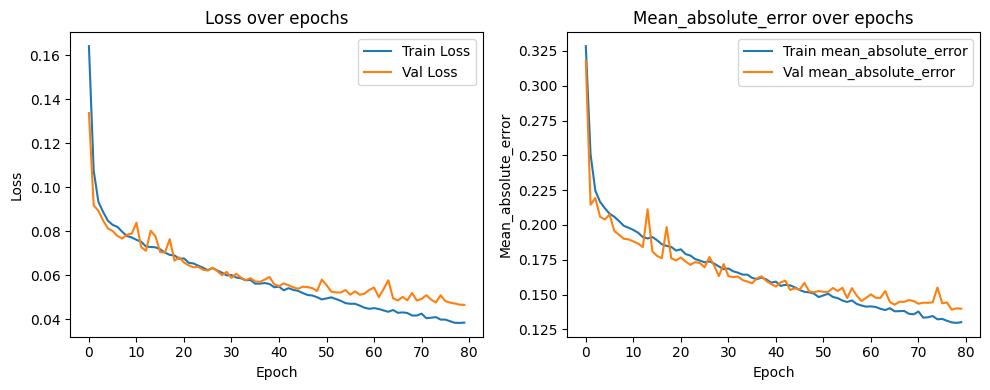

In [64]:
results_df, mse, mae, r2 = evaluate_regression_model(model, [X_test_cnn, X_test_lstm], y_test)

history_dicts = [history.history, history1.history, history2.history, history3.history, history4.history, history5.history]
full_history = {key: sum((hist[key] for hist in history_dicts), []) for key in history.history.keys()}
full_history_obj = History()
full_history_obj.history = full_history

plot_learning_curves(full_history_obj, metric='mean_absolute_error')

In [66]:
model.save_weights('before_continued_training.weights.h5')

In [17]:
model.load_weights('before_continued_training.weights.h5')

d:\polina\CRISPR\RNA-FM\ensemble\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 48 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [19]:
history5 = model.fit(
    [X_train_cnn, X_train_lstm], y_train,
    epochs=30,
    batch_size=BATCH_SIZE,
    validation_data=([X_test_cnn, X_test_lstm], y_test)
)

Epoch 1/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 74s 200ms/step - loss: 0.0367 - mean_absolute_error: 0.1273 - val_loss: 0.0476 - val_mean_absolute_error: 0.1415
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 27s 163ms/step - loss: 0.0376 - mean_absolute_error: 0.1298 - val_loss: 0.0480 - val_mean_absolute_error: 0.1448
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 26s 160ms/step - loss: 0.0365 - mean_absolute_error: 0.1263 - val_loss: 0.0522 - val_mean_absolute_error: 0.1446
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - loss: 0.0382 - mean_absolute_error: 0.1297 - val_loss: 0.0489 - val_mean_absolute_error: 0.1489
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 28s 169ms/step - loss: 0.0361 - mean_absolute_error: 0.1266 - val_loss: 0.0459 - val_mean_absolute_error: 0.1402
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 28s 167ms/step - loss: 0.0371 - mean_absolute_error: 0.1278 - val_loss: 0.0461 - val_mean_absolute_error: 0.1390
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 29s 177ms/step - loss: 0.0351 - mean_absol

165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0425 - mean_absolute_error: 0.1328
Test Loss (MSE): 0.04377
Test MAE: 0.13505
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.04377
Mean Absolute Error (MAE): 0.13505
R² Score: 0.71307


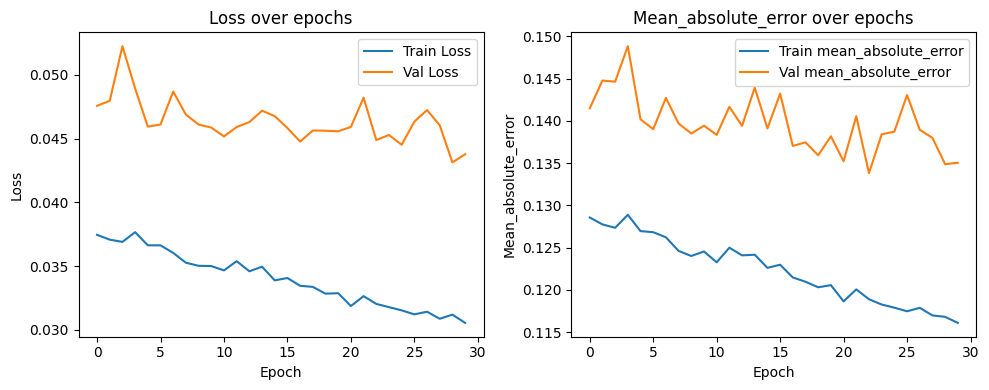

In [20]:
results_df, mse, mae, r2 = evaluate_regression_model(model, [X_test_cnn, X_test_lstm], y_test)
plot_learning_curves(history5, metric='mean_absolute_error')

In [21]:
history6 = model.fit(
    [X_train_cnn, X_train_lstm], y_train,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=([X_test_cnn, X_test_lstm], y_test)
)

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 69s 274ms/step - loss: 0.0301 - mean_absolute_error: 0.1157 - val_loss: 0.0434 - val_mean_absolute_error: 0.1353
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 29s 174ms/step - loss: 0.0294 - mean_absolute_error: 0.1145 - val_loss: 0.0474 - val_mean_absolute_error: 0.1374
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 28s 168ms/step - loss: 0.0305 - mean_absolute_error: 0.1153 - val_loss: 0.0448 - val_mean_absolute_error: 0.1385
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 27s 165ms/step - loss: 0.0285 - mean_absolute_error: 0.1127 - val_loss: 0.0430 - val_mean_absolute_error: 0.1335
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 29s 174ms/step - loss: 0.0304 - mean_absolute_error: 0.1149 - val_loss: 0.0440 - val_mean_absolute_error: 0.1381
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 29s 174ms/step - loss: 0.0287 - mean_absolute_error: 0.1136 - val_loss: 0.0444 - val_mean_absolute_error: 0.1355
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 30s 184ms/step - loss: 0.0301 - mean_absol

165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0464 - mean_absolute_error: 0.1356
Test Loss (MSE): 0.04679
Test MAE: 0.13630
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.04679
Mean Absolute Error (MAE): 0.13630
R² Score: 0.69327


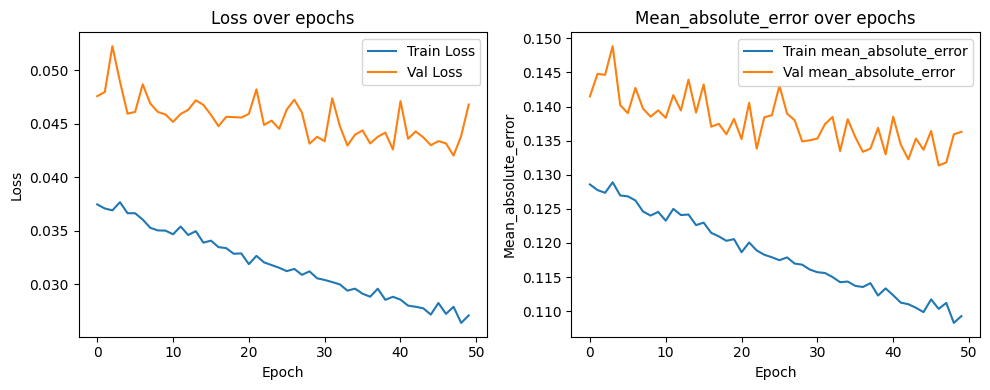

In [24]:
results_df, mse, mae, r2 = evaluate_regression_model(model, [X_test_cnn, X_test_lstm], y_test)

history_dicts = [history5.history, history6.history]
full_history = {key: sum((hist[key] for hist in history_dicts), []) for key in history5.history.keys()}
full_history_obj = History()
full_history_obj.history = full_history

plot_learning_curves(full_history_obj, metric='mean_absolute_error')

In [25]:
history7 = model.fit(
    [X_train_cnn, X_train_lstm], y_train,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=([X_test_cnn, X_test_lstm], y_test)
)

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 28s 161ms/step - loss: 0.0274 - mean_absolute_error: 0.1100 - val_loss: 0.0425 - val_mean_absolute_error: 0.1335
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - loss: 0.0246 - mean_absolute_error: 0.1048 - val_loss: 0.0431 - val_mean_absolute_error: 0.1326
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 31s 186ms/step - loss: 0.0246 - mean_absolute_error: 0.1060 - val_loss: 0.0431 - val_mean_absolute_error: 0.1333
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 30s 183ms/step - loss: 0.0249 - mean_absolute_error: 0.1058 - val_loss: 0.0428 - val_mean_absolute_error: 0.1347
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - loss: 0.0260 - mean_absolute_error: 0.1076 - val_loss: 0.0449 - val_mean_absolute_error: 0.1353
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 27s 163ms/step - loss: 0.0263 - mean_absolute_error: 0.1070 - val_loss: 0.0422 - val_mean_absolute_error: 0.1335
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 39s 151ms/step - loss: 0.0256 - mean_absol

165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0412 - mean_absolute_error: 0.1312
Test Loss (MSE): 0.04308
Test MAE: 0.13441
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.04308
Mean Absolute Error (MAE): 0.13441
R² Score: 0.71762


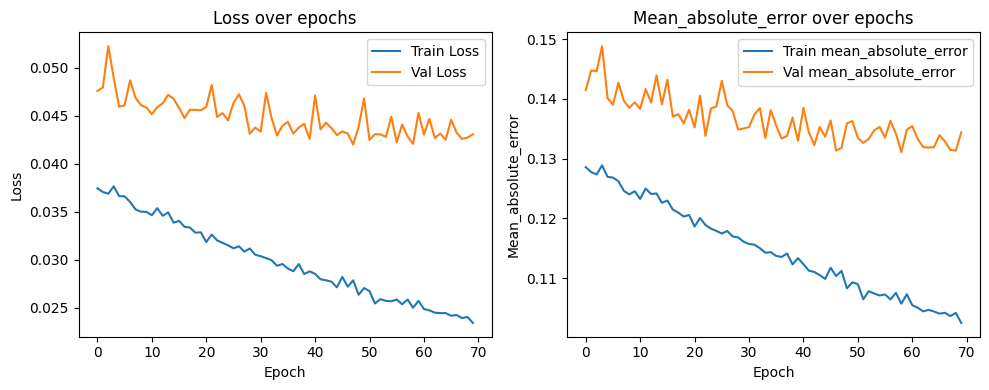

In [26]:
results_df, mse, mae, r2 = evaluate_regression_model(model, [X_test_cnn, X_test_lstm], y_test)

history_dicts = [history5.history, history6.history, history7.history]
full_history = {key: sum((hist[key] for hist in history_dicts), []) for key in history5.history.keys()}
full_history_obj = History()
full_history_obj.history = full_history

plot_learning_curves(full_history_obj, metric='mean_absolute_error')

In [27]:
history8 = model.fit(
    [X_train_cnn, X_train_lstm], y_train,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=([X_test_cnn, X_test_lstm], y_test)
)

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 29s 176ms/step - loss: 0.0240 - mean_absolute_error: 0.1037 - val_loss: 0.0437 - val_mean_absolute_error: 0.1328
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 26s 156ms/step - loss: 0.0225 - mean_absolute_error: 0.1009 - val_loss: 0.0433 - val_mean_absolute_error: 0.1348
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 28s 170ms/step - loss: 0.0231 - mean_absolute_error: 0.1023 - val_loss: 0.0424 - val_mean_absolute_error: 0.1311
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 30s 184ms/step - loss: 0.0225 - mean_absolute_error: 0.1009 - val_loss: 0.0416 - val_mean_absolute_error: 0.1312
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 29s 173ms/step - loss: 0.0221 - mean_absolute_error: 0.1012 - val_loss: 0.0430 - val_mean_absolute_error: 0.1322
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 28s 169ms/step - loss: 0.0220 - mean_absolute_error: 0.0994 - val_loss: 0.0439 - val_mean_absolute_error: 0.1334
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 27s 164ms/step - loss: 0.0243 - mean_absol

165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0416 - mean_absolute_error: 0.1298
Test Loss (MSE): 0.04299
Test MAE: 0.13209
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.04299
Mean Absolute Error (MAE): 0.13209
R² Score: 0.71817


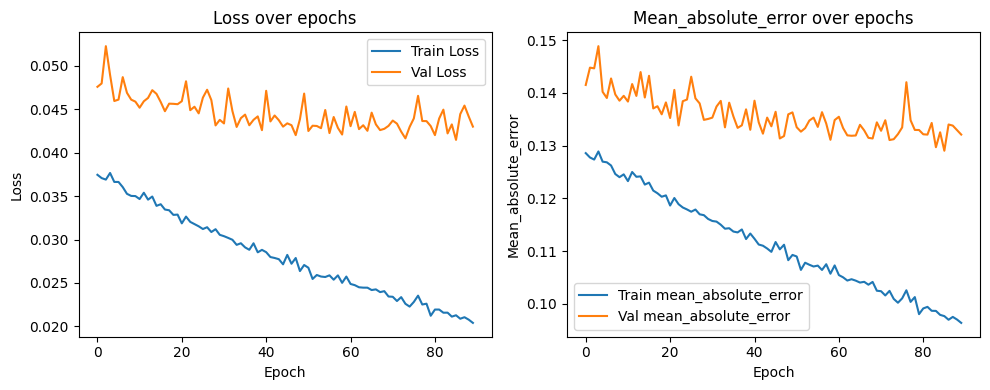

In [28]:
results_df, mse, mae, r2 = evaluate_regression_model(model, [X_test_cnn, X_test_lstm], y_test)

history_dicts = [history5.history, history6.history, history7.history, history8.history]
full_history = {key: sum((hist[key] for hist in history_dicts), []) for key in history5.history.keys()}
full_history_obj = History()
full_history_obj.history = full_history

plot_learning_curves(full_history_obj, metric='mean_absolute_error')